# Analysing POIs in Leisure Walk Description Dataset

Loading the walkingmap dataset, download OSM POIs and annotate the POI dataset.

Using topic modelling to discover different types of POIs in leisure walk description dataset.

## Setup

Loading libraries and models

In [1]:
# working with files
import os.path
# sys
import sys

# warning off
import warnings
# IO
import json
# calling Webservices
import requests
# systematic thread stops for polite crawling
import time

# set random seed for reproducibility of results
from umap import UMAP

# dataframe 
import numpy as np
import pandas as pd
import geopandas as gpd

# geocoding
from geopy.geocoders import Nominatim

# getting data from OSM
import osmnx as ox

# topic modelling
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired

# nlp
from sentence_transformers import SentenceTransformer, util
import spacy
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt

# logging
from loguru import logger

# set logger level
logger.remove(0)
logger.add(sys.stderr, level="INFO")

warnings.filterwarnings("ignore")

# en_core_web_lg must be downloaded, if not run: 'python -m spacy download en_core_web_lg' first!
nlp = spacy.load('en_core_web_lg')

umap_model = UMAP(random_state=42)

stopword_removal = False

## Dataset

Reading the dataset crawled from WalkingMap website.

In [2]:
with open('dataset/walkingmaps.json', 'r', encoding='utf-8') as fp:
    dataset = json.load(fp)

In [3]:
logger.debug(f'an example record in dataset: {dataset[1]}')
logger.info(f'structure of records in dataset: {dataset[1].keys()}')

2024-03-02 09:41:29.159 | INFO     | __main__:<module>:2 - structure of records in dataset: dict_keys(['markers', 'pathDetails', 'pois', 'title', 'description'])


### Dataset Transformation

Aim: Transforming the dataset into pandas and geopandas dataframes, with a focus on POIs

A basic preprocessing step to create a dataset of POI descriptions, also including A preliminary analysis their location.

In [4]:
counter = 0
total = 0
for record in dataset:
    if 'pois' in record.keys() and len(record['pois']) > 0:
        counter+=1
        total += len(record['pois'])
logger.info('records: {0} total POIs: {1} - average per record: {2}'.format(counter, total, round(total/counter)))

2024-03-02 09:41:29.173 | INFO     | __main__:<module>:7 - records: 386 total POIs: 4392 - average per record: 11


In [5]:
data_structure = {'record_title':[], 'record_description':[], 'poi_title':[], 'poi_summary':[], 'latitude': [], 'longitude': []}
for record in dataset:
    if 'pois' in record.keys() and len(record['pois']) > 0:
        for poi in record['pois']:
            data_structure['record_title'].append(record['title'])
            data_structure['record_description'].append(record['description'])
            data_structure['poi_title'].append(poi['title'])
            data_structure['poi_summary'].append(poi['summary'])
            data_structure['latitude'].append(poi['lat'])
            data_structure['longitude'].append(poi['lng'])

In [6]:
df = pd.DataFrame(data_structure)

gdf = gpd.GeoDataFrame(df[['poi_title', 'poi_summary', 'latitude', 'longitude']], geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

In [7]:
# gdf.explore()   # map visualization of the POIs

In [8]:
gdf.head()

,poi_title,poi_summary,latitude,longitude,geometry
0,Fairhaven Surf Life Saving Club,Fairhaven is a well known surf beach. The beac...,-38.468759,144.084459,POINT (144.08446 -38.46876)
1,Beach walk,"From Sprout Creek, Eastern View, Moggs Creek, ...",-38.468542,144.089693,POINT (144.08969 -38.46854)
2,Rock pools,See what sort of shells and stones you can col...,-38.468459,144.092420,POINT (144.09242 -38.46846)
3,Sand dunes,The beautiful rolling sand dunes shape the bea...,-38.468418,144.095318,POINT (144.09532 -38.46842)
4,Painkalac Creek,The creek separates Aireys Inlet from Fairhave...,-38.468390,144.097312,POINT (144.09731 -38.46839)


In [9]:
df.head()

,record_title,record_description,poi_title,poi_summary,latitude,longitude
0,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Fairhaven Surf Life Saving Club,Fairhaven is a well known surf beach. The beac...,-38.468759,144.084459
1,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Beach walk,"From Sprout Creek, Eastern View, Moggs Creek, ...",-38.468542,144.089693
2,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Rock pools,See what sort of shells and stones you can col...,-38.468459,144.092420
3,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Sand dunes,The beautiful rolling sand dunes shape the bea...,-38.468418,144.095318
4,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Painkalac Creek,The creek separates Aireys Inlet from Fairhave...,-38.468390,144.097312


## Topic Modelling - Raw Inputs

**Aim**: Findings topics describing the POIs using BERT embeddings

**Approach**: Using raw textual description (title + summary) and feed it BERTopic for categorisation. Manunally investigating the categories to find out the categories are coherent and meaningful.

In [10]:
gdf['description'] = gdf['poi_title']+': '+gdf['poi_summary']

In [11]:
def remove_stopwords(row):
    return ' '.join([w for w in row['description'].split() if w.lower() not in stopwords.words('english')])

In [12]:
if stopword_removal:
    gdf['description'] = gdf.apply(remove_stopwords, axis=1)

In [13]:
gdf.head()

,poi_title,poi_summary,latitude,longitude,geometry,description
0,Fairhaven Surf Life Saving Club,Fairhaven is a well known surf beach. The beac...,-38.468759,144.084459,POINT (144.08446 -38.46876),Fairhaven Surf Life Saving Club: Fairhaven is ...
1,Beach walk,"From Sprout Creek, Eastern View, Moggs Creek, ...",-38.468542,144.089693,POINT (144.08969 -38.46854),"Beach walk: From Sprout Creek, Eastern View, M..."
2,Rock pools,See what sort of shells and stones you can col...,-38.468459,144.092420,POINT (144.09242 -38.46846),Rock pools: See what sort of shells and stones...
3,Sand dunes,The beautiful rolling sand dunes shape the bea...,-38.468418,144.095318,POINT (144.09532 -38.46842),Sand dunes: The beautiful rolling sand dunes s...
4,Painkalac Creek,The creek separates Aireys Inlet from Fairhave...,-38.468390,144.097312,POINT (144.09731 -38.46839),Painkalac Creek: The creek separates Aireys In...


In [14]:
docs = list(gdf['description'])
raw_model_path = 'outputs/model/raw_poi_descriptions'

overwrite = False
already_saved = False
if os.path.isfile(raw_model_path) and not overwrite:
    logger.info('model found in outputs folder')
    already_saved = True
    topic_model = BERTopic.load(raw_model_path)
    topics, probs = topic_model.topics_, topic_model.probabilities_
    logger.info(f'model is loaded from {raw_model_path}')
else:
    logger.info(f'model not found, will be created...')
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    topic_model = BERTopic(umap_model=umap_model, ctfidf_model=ctfidf_model)
    topics, probs = topic_model.fit_transform(docs)
    topic_model.save(raw_model_path, serialization='pickle')
    logger.info(f'model saved in {raw_model_path}')

2024-03-02 09:41:29.529 | INFO     | __main__:<module>:7 - model found in outputs folder
2024-03-02 09:41:33.742 | INFO     | __main__:<module>:11 - model is loaded from outputs/model/raw_poi_descriptions


In [15]:
topic_model.get_topic_info().head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1454,-1_reserve_street_through_hall,"[reserve, street, through, hall, water, centre...",[Boroondara Shops: A great little shopping str...
1,0,328,0_track_steep_signage_gravel,"[track, steep, signage, gravel, top, path, wal...",[The walking route: The route is flat and acce...
2,1,165,1_beach_bay_sand_tide,"[beach, bay, sand, tide, breakwater, surf, coa...","[Beach walkers: If the tide is out, walking al..."
3,2,161,2_bridge_pedestrian_footbridge_railway,"[bridge, pedestrian, footbridge, railway, unde...",[Overhead Railway Bridge : The Overhead Bridge...
4,3,148,3_sculpture_artists_mural_art,"[sculpture, artists, mural, art, wall, artwork...",[Three Businessmen Who Brought Their Own Lunch...


In [16]:
experiment_name = 'raw-poi'

intertopic_distance_map_html_path = f'outputs/figure/intertopic-dmap-{experiment_name}.html'
intertopic_distance_map_image_path = f'outputs/figure/intertopic-dmap-{experiment_name}.png'

topic_hierarchy_html_path = f'outputs/figure/topic-hierarchy-{experiment_name}.html'
topic_hierarchy_image_path = f'outputs/figure/topic-hierarchy-{experiment_name}.png'

detailed_topic_hierarchy_html_path = f'outputs/figure/detailed-topic-hierarchy-{experiment_name}.html'
detailed_topic_hierarchy_image_path = f'outputs/figure/detailed-topic-hierarchy-{experiment_name}.png'

barchart_html_path = f'outputs/figure/barchart-{experiment_name}.html'
barchart_image_path = f'outputs/figure/barchart-{experiment_name}.png'

heatmap_html_path = f'outputs/figure/heatmap-{experiment_name}.html'
heatmap_image_path = f'outputs/figure/heatmap-{experiment_name}.png'

In [17]:
fig = topic_model.visualize_topics()

if not overwrite and os.path.isfile(intertopic_distance_map_html_path):
    logger.info('figures already saved in HTML and image formats')
else:
    fig.write_html(intertopic_distance_map_html_path)
    fig.write_image(intertopic_distance_map_image_path)
    logger.info(f'figures saved in: \n\t{intertopic_distance_map_html_path}\n\t{intertopic_distance_map_image_path}')

fig

2024-03-02 09:41:43.806 | INFO     | __main__:<module>:4 - figures already saved in HTML and image formats


In [18]:
fig = topic_model.visualize_hierarchy()
if os.path.isfile(topic_hierarchy_html_path) and not overwrite:
    logger.info('figure is already saved in HTML and image format')
else:
    fig.write_html(topic_hierarchy_html_path)
    fig.write_image(topic_hierarchy_image_path)
    logger.info(f'figures saved in: \n\t{topic_hierarchy_html_path}\n\t{topic_hierarchy_image_path}')


fig

2024-03-02 09:41:44.812 | INFO     | __main__:<module>:3 - figure is already saved in HTML and image format


In [19]:
# what happen when merging topics as well
hierarchical_topics = topic_model.hierarchical_topics(docs)
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

if not overwrite and os.path.isfile(detailed_topic_hierarchy_html_path):
    logger.info('figures already saved in HTML and image formats')
else:    
    fig.write_html(detailed_topic_hierarchy_html_path)
    fig.write_image(detailed_topic_hierarchy_image_path)
    logger.info(f'figures saved in: \n\t{detailed_topic_hierarchy_html_path}\n\t{detailed_topic_hierarchy_image_path}')

fig

100%|██████████| 62/62 [00:00<00:00, 163.91it/s]
2024-03-02 09:41:45.378 | INFO     | __main__:<module>:6 - figures already saved in HTML and image formats


In [20]:
fig = topic_model.visualize_barchart()

if not overwrite and os.path.isfile(barchart_html_path):
    logger.info('figure is already saved in HTML and image formats')
else:
    fig.write_html(barchart_html_path)
    fig.write_image(barchart_image_path)
    logger.info(f'figures saved in: \n\t{barchart_html_path}\n\t{barchart_image_path}')

fig

2024-03-02 09:41:45.590 | INFO     | __main__:<module>:4 - figure is already saved in HTML and image formats


In [21]:
fig = topic_model.visualize_heatmap()

if not overwrite and os.path.isfile(heatmap_html_path):
    logger.info('figure is already saved in HTML and image format')
else:
    fig.write_html(heatmap_html_path)
    fig.write_image(heatmap_image_path)
    logger.info(f'figures saved in: \n\t{heatmap_html_path}\n\t{heatmap_image_path}')

fig

2024-03-02 09:41:45.862 | INFO     | __main__:<module>:4 - figure is already saved in HTML and image format


In [22]:
# topic outlier reduction - if necessary (todo)
topics = topic_model.reduce_outliers(docs, topics, strategy="c-tf-idf")

In [23]:
topic_df = pd.DataFrame({'topic': topics, 'document': docs})

In [24]:
topic_df.head()

,topic,document
0,1,Fairhaven Surf Life Saving Club: Fairhaven is ...
1,1,"Beach walk: From Sprout Creek, Eastern View, M..."
2,12,Rock pools: See what sort of shells and stones...
3,1,Sand dunes: The beautiful rolling sand dunes s...
4,35,Painkalac Creek: The creek separates Aireys In...


In [25]:
topic_df.to_csv('outputs/dataframes/raw-topic-poi-description.csv')

### Conclusions 
Some categories are not atomic, several biases toward famous geographic names including LGAs and suburbs. Removing the geographic names from the POI descriptions will help to understand 'what' categories they belong rather than 'where' they are.

#### Work ToDo:
1. **Classification**: Analysing the hierarchical organization of topics to define classes describing what POIs are described.
2. **Space and Classes/Topics**: LGA? SA2/SA3? Question: Is there a relationship between categories and location - how it changes before and after removing place names?
3. **Walks and Classes/Topics**: Type of the walk - finding a categorization of leisure walks and check the association of topics to leisure walk purpose. Question: Is there a association between walks/categories of walks and certian POIs selected based on their classification/topics.

### Possible Future Work: Multimodel Topic Modelling

Using both text and images for topic modelling.

Could be a good future work or an extension to the work - I need change the crawler information for this to capture links for description and also for images.

See: https://maartengr.github.io/BERTopic/getting_started/multimodal/multimodal.html#text-images

## OSM Points of Interests

**Aim**: Collect rich OSM POI information in the bounding box area of the lesiure walk.

**Approach**: Using OSM tags for `{'amenity': True, 'natural': True, 'animal': True, 'leisure': True}` to collect information inside the bounding boxes of leisure walks.

In [26]:
# bounding box of each path
paths = []
for record in dataset:
    min_lat = 90
    max_lat = -90
    min_lng = 180
    max_lng = -180
    for latlng in record['pathDetails']:
        if min_lat > latlng['lat']:
            min_lat = latlng['lat']
        if max_lat < latlng['lat']:
            max_lat = latlng['lat']
        if min_lng > latlng['lng']:
            min_lng = latlng['lng']
        if max_lng < latlng['lng']:
            max_lng = latlng['lng']
    paths.append({'min_lat': min_lat, 'max_lat': max_lat, 'min_lng': min_lng, 'max_lng': max_lng})

In [27]:
logger.debug(f'all path bounding boxes: {paths}')  # bounding box information leisure walks
logger.info(f'example path bounding boxes: {paths[0]}')  # bounding box information leisure walks

2024-03-02 09:41:46.065 | INFO     | __main__:<module>:2 - example path bounding boxes: {'min_lat': -37.82326007, 'max_lat': -37.81401352, 'min_lng': 144.96751249, 'max_lng': 144.97828424}


In [28]:
tags = {'amenity': True, 'natural': True, 'animal': True, 'leisure': True}

In [29]:
path = paths[0]
feature_gdf = ox.features_from_bbox(north=path['max_lat'], south=path['min_lat'], east=path['max_lng'], west=path['min_lng'], tags=tags)

In [30]:
# feature_gdf.explore()  # example output - map visualization

In [31]:
feature_gdf.head()

addr:city addr:housenumber addr:postcode  \
element_type osmid                                                 
node         176729780  Melbourne              191          3000   
             243097159        NaN              NaN           NaN   
             247024808        NaN              NaN           NaN   
             247689970        NaN              NaN           NaN   
             266733834        NaN              NaN           NaN   

                           addr:street           amenity  \
element_type osmid                                         
node         176729780  Collins Street           theatre   
             243097159             NaN      loading_dock   
             247024808             NaN  parking_entrance   
             247689970             NaN  parking_entrance   
             266733834             NaN           parking   

                                         name        operator  \
element_type osmid                                              
node         176729780         Regent Theatre  Marriner Group   
             243097159                    NaN             NaN   
             247024808                    NaN             NaN   
             247689970                    NaN             NaN   
             266733834  Sofitel Hotel Carpark  Wilson Parking   

                                                                  website  \
element_type osmid                                                          
node         176729780  https://www.marrinergroup.com.au/theatre-regen...   
             243097159                                                NaN   
             247024808                                                NaN   
             247689970                                                NaN   
             266733834                                                NaN   

                        wikidata                     geometry  ...  bus  \
element_type osmid                                             ...        
node         176729780  Q7308110  POINT (144.96760 -37.81550)  ...  NaN   
             243097159       NaN  POINT (144.96796 -37.82161)  ...  NaN   
             247024808       NaN  POINT (144.97019 -37.81548)  ...  NaN   
             247689970       NaN  POINT (144.97070 -37.81789)  ...  NaN   
             266733834       NaN  POINT (144.97302 -37.81451)  ...  NaN   

                       motor_vehicle building:part not:operator:wikidata  \
element_type osmid                                                         
node         176729780           NaN           NaN                   NaN   
             243097159           NaN           NaN                   NaN   
             247024808           NaN           NaN                   NaN   
             247689970           NaN           NaN                   NaN   
             266733834           NaN           NaN                   NaN   

                       water unisex ways type intermittent salt  
element_type osmid                                               
node         176729780   NaN    NaN  NaN  NaN          NaN  NaN  
             243097159   NaN    NaN  NaN  NaN          NaN  NaN  
             247024808   NaN    NaN  NaN  NaN          NaN  NaN  
             247689970   NaN    NaN  NaN  NaN          NaN  NaN  
             266733834   NaN    NaN  NaN  NaN          NaN  NaN  

[5 rows x 132 columns]

In [32]:
logger.debug(f'feature columns: {feature_gdf.columns}')
logger.info(f'number of feature columns in feature gdf: {len(feature_gdf.columns)}')

2024-03-02 09:41:46.867 | INFO     | __main__:<module>:2 - number of feature columns in feature gdf: 132


In [33]:
feature_gdf.amenity = feature_gdf.amenity.astype(str)
feature_gdf.natural = feature_gdf.natural.astype(str)
feature_gdf.leisure = feature_gdf.leisure.astype(str)
feature_gdf.name = feature_gdf.name.astype(str)

In [34]:
feature_gdf = feature_gdf[['name', 'amenity', 'natural', 'leisure', 'geometry']].dropna(how='all')
feature_gdf.head()

name           amenity natural  \
element_type osmid                                                        
node         176729780         Regent Theatre           theatre     nan   
             243097159                    nan      loading_dock     nan   
             247024808                    nan  parking_entrance     nan   
             247689970                    nan  parking_entrance     nan   
             266733834  Sofitel Hotel Carpark           parking     nan   

                       leisure                     geometry  
element_type osmid                                           
node         176729780     nan  POINT (144.96760 -37.81550)  
             243097159     nan  POINT (144.96796 -37.82161)  
             247024808     nan  POINT (144.97019 -37.81548)  
             247689970     nan  POINT (144.97070 -37.81789)  
             266733834     nan  POINT (144.97302 -37.81451)

In [35]:
for idx, path in enumerate(paths):
    
    if os.path.isfile('dataset/features-osm-{}.geojson'.format(idx)):
        logger.debug('features for path {0} out of {1} is already loaded and saved.'.format(idx, len(paths)))
        continue;
    try:
        feature_gdf = ox.features_from_bbox(north=path['max_lat'], south=path['min_lat'], east=path['max_lng'], west=path['min_lng'], tags=tags)
        cols = feature_gdf.columns
        #preprocess
        if 'amenity' not in cols:
            feature_gdf['amenity'] = np.nan
        feature_gdf.amenity = feature_gdf.amenity.astype(str)    
        if 'natural' not in cols:
            feature_gdf['natural'] = np.nan
        feature_gdf.natural = feature_gdf.natural.astype(str)    
        if 'leisure' not in cols:
            feature_gdf['leisure'] = np.nan
        feature_gdf.leisure = feature_gdf.leisure.astype(str)
        if 'name' not in cols:
            feature_gdf['name'] = np.nan
        feature_gdf.name = feature_gdf.name.astype(str)
        feature_gdf = feature_gdf[['name', 'amenity', 'natural', 'leisure', 'geometry']].dropna(how='all')
    
        feature_gdf.to_file("dataset/features-osm-{}.geojson".format(idx), driver='GeoJSON')
        logger.info('features for path {0} out of {1} is loaded from OSM and saved ...'.format(idx, len(paths)))
    except Exception as e:
        logger.warning('error in writing path {0} out of {1}...'.format(idx, len(paths)))
        logger.warning(e)

C:\Users\Ehsan\AppData\Local\Temp\ipykernel_13704\2879821958.py:7: FutureWarning:

The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.

2024-03-02 09:41:47.047 | WARNING  | __main__:<module>:27 - error in writing path 59 out of 387...
2024-03-02 09:41:47.049 | WARNING  | __main__:<module>:28 - No data elements in server response. Check log and query location/tags.
C:\Users\Ehsan\AppData\Local\Temp\ipykernel_13704\2879821958.py:7: FutureWarning:

The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.

2024-03-02 09:41:47.145 | WARNING  | __main__:<module>:27 - error in writing path 128 out of 387...
2024-03-02 09:41:47.147 | WARNING  | __main__:<module>:28 - No data elements in server response. Check log and query location/tags.


C:\Users\Ehsan\AppData\Local\Temp\ipykernel_13704\2879821958.py:7: FutureWarning:

The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.

2024-03-02 09:41:47.247 | WARNING  | __main__:<module>:27 - error in writing path 151 out of 387...
2024-03-02 09:41:47.248 | WARNING  | __main__:<module>:28 - No data elements in server response. Check log and query location/tags.
C:\Users\Ehsan\AppData\Local\Temp\ipykernel_13704\2879821958.py:7: FutureWarning:

The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.

2024-03-02 09:41:47.359 | WARNING  | __main__:<module>:27 - error in writing path 309 out of 387...
2024-03-02 09:41:47.360 | WARNING  | __main__:<module>:28 - No data elements in server response. Check log and query location/tags.
C:\Users\Ehsan\AppData\Local\Temp\ipykernel_13704\2879821958.py:7: FutureWarning

In [36]:
feature_gdf.head()

name           amenity natural  \
element_type osmid                                                        
node         176729780         Regent Theatre           theatre     nan   
             243097159                    nan      loading_dock     nan   
             247024808                    nan  parking_entrance     nan   
             247689970                    nan  parking_entrance     nan   
             266733834  Sofitel Hotel Carpark           parking     nan   

                       leisure                     geometry  
element_type osmid                                           
node         176729780     nan  POINT (144.96760 -37.81550)  
             243097159     nan  POINT (144.96796 -37.82161)  
             247024808     nan  POINT (144.97019 -37.81548)  
             247689970     nan  POINT (144.97070 -37.81789)  
             266733834     nan  POINT (144.97302 -37.81451)

## Matching POIs to OSM POIs

**Aim** To match collected OSM POIs with described POIs

**Approach** using textual matching of POIs description to OSM tags (*semantic criterion*) and spatial matching based on proximity (*spatial criterion*):

- spatial criterion: defining containment
- semantic criterion: defining semantic similarity using word embeddings

### Semantic Matching

Ranking the relevance of textual descriptions in OSM POIs and LW POIS

Example to test how it works

In [37]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens') # symmetric semantic search
msmarco_model = SentenceTransformer('sentence-transformers/msmarco-distilbert-dot-v5')  # asymmetric semantic search

# embedding derived from BERT for the pois
def embed_texts(sentences, model=sbert_model):
    sentence_embeddings = model.encode(sentences)
    return sentence_embeddings


def compute_similarities(query, sentences, sentence_embeddings, model=sbert_model):
    query_vec = embed_texts(query)
    scores = util.dot_score(query_vec, sentence_embeddings)[0].cpu().tolist()
    doc_score_pairs = list(zip(sentences, scores))
    doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)
    logger.debug("Query:", query)
    for doc, score in doc_score_pairs:
        logger.info(f'\t{score}\t{doc}')
    return doc_score_pairs

In [38]:
def only_noun_phrases(sentence):
    doc = nlp(sentence)
    phrases = set() 
    for nc in doc.noun_chunks:
        phrases.add(nc.text)
        phrases.add(doc[nc.root.left_edge.i:nc.root.right_edge.i+1].text)
    return ' '.join(phrases)

In [39]:
example_poi_osm = "Gaswork park theatre"
example_sentences = ["Gasworks Park: There are artists studios, a theatre and a cafe. Every 3rd Saturday there is a Farmers' Market.  In the park you'll also come across various wonderful sculptures and installations.",
                                                 "Australia's Number One university and world leader in education, teaching and research excellence.",
                                                 "Completed in 1870, the Melbourne Town Hall is at the heart of the city's cultural and civic activity",
                                                 "The magnificent octagonal domed reading room is both a quiet space for study and an iconic Melbourne location to take an unforgettable selfie.?"]
example_sentence_embeddings = embed_texts(example_sentences)
compute_similarities(example_poi_osm, example_sentences, example_sentence_embeddings)

2024-03-02 09:41:56.719 | INFO     | __main__:compute_similarities:17 - 	112.5803451538086	Completed in 1870, the Melbourne Town Hall is at the heart of the city's cultural and civic activity
2024-03-02 09:41:56.721 | INFO     | __main__:compute_similarities:17 - 	92.63168334960938	Gasworks Park: There are artists studios, a theatre and a cafe. Every 3rd Saturday there is a Farmers' Market.  In the park you'll also come across various wonderful sculptures and installations.
2024-03-02 09:41:56.722 | INFO     | __main__:compute_similarities:17 - 	84.31318664550781	The magnificent octagonal domed reading room is both a quiet space for study and an iconic Melbourne location to take an unforgettable selfie.?
2024-03-02 09:41:56.722 | INFO     | __main__:compute_similarities:17 - 	62.57233810424805	Australia's Number One university and world leader in education, teaching and research excellence.


[("Completed in 1870, the Melbourne Town Hall is at the heart of the city's cultural and civic activity",
  112.5803451538086),
 ("Gasworks Park: There are artists studios, a theatre and a cafe. Every 3rd Saturday there is a Farmers' Market.  In the park you'll also come across various wonderful sculptures and installations.",
  92.63168334960938),
 ('The magnificent octagonal domed reading room is both a quiet space for study and an iconic Melbourne location to take an unforgettable selfie.?',
  84.31318664550781),
 ("Australia's Number One university and world leader in education, teaching and research excellence.",
  62.57233810424805)]

In [40]:
# with preprocessing
only_noun_example_sentences = [only_noun_phrases(sentence) for sentence in example_sentences]
example_sentence_embeddings = embed_texts(only_noun_example_sentences)
compute_similarities(example_poi_osm, only_noun_example_sentences, example_sentence_embeddings)

2024-03-02 09:41:57.120 | INFO     | __main__:compute_similarities:17 - 	127.11270141601562	Gasworks Park various wonderful sculptures and installations the park you installations various wonderful sculptures a Farmers' Market Gasworks Park: a cafe a theatre artists studios a theatre and a cafe artists studios, a theatre and a cafe
2024-03-02 09:41:57.122 | INFO     | __main__:compute_similarities:17 - 	117.82975769042969	the Melbourne Town Hall the heart the heart of the city's cultural and civic activity the city's cultural and civic activity
2024-03-02 09:41:57.122 | INFO     | __main__:compute_similarities:17 - 	76.43304443359375	an iconic Melbourne location The magnificent octagonal domed reading room an iconic Melbourne location to take an unforgettable selfie a quiet space for study and an iconic Melbourne location to take an unforgettable selfie an unforgettable selfie study a quiet space
2024-03-02 09:41:57.123 | INFO     | __main__:compute_similarities:17 - 	59.44733810424805

[("Gasworks Park various wonderful sculptures and installations the park you installations various wonderful sculptures a Farmers' Market Gasworks Park: a cafe a theatre artists studios a theatre and a cafe artists studios, a theatre and a cafe",
  127.11270141601562),
 ("the Melbourne Town Hall the heart the heart of the city's cultural and civic activity the city's cultural and civic activity",
  117.82975769042969),
 ('an iconic Melbourne location The magnificent octagonal domed reading room an iconic Melbourne location to take an unforgettable selfie a quiet space for study and an iconic Melbourne location to take an unforgettable selfie an unforgettable selfie study a quiet space',
  76.43304443359375),
 ("Australia's Number One university and world leader in education, teaching and research excellence. excellence education education, teaching and research excellence teaching research teaching and research excellence Australia's Number One university and world leader",
  59.447338

In [41]:
example_sentence_embeddings = embed_texts(example_sentences, model=msmarco_model)
compute_similarities(example_poi_osm, example_sentences, example_sentence_embeddings, model=msmarco_model)

2024-03-02 09:41:57.327 | INFO     | __main__:compute_similarities:17 - 	42.83140182495117	Gasworks Park: There are artists studios, a theatre and a cafe. Every 3rd Saturday there is a Farmers' Market.  In the park you'll also come across various wonderful sculptures and installations.
2024-03-02 09:41:57.328 | INFO     | __main__:compute_similarities:17 - 	30.71784019470215	Completed in 1870, the Melbourne Town Hall is at the heart of the city's cultural and civic activity
2024-03-02 09:41:57.329 | INFO     | __main__:compute_similarities:17 - 	25.08165740966797	The magnificent octagonal domed reading room is both a quiet space for study and an iconic Melbourne location to take an unforgettable selfie.?
2024-03-02 09:41:57.330 | INFO     | __main__:compute_similarities:17 - 	18.95928382873535	Australia's Number One university and world leader in education, teaching and research excellence.


[("Gasworks Park: There are artists studios, a theatre and a cafe. Every 3rd Saturday there is a Farmers' Market.  In the park you'll also come across various wonderful sculptures and installations.",
  42.83140182495117),
 ("Completed in 1870, the Melbourne Town Hall is at the heart of the city's cultural and civic activity",
  30.71784019470215),
 ('The magnificent octagonal domed reading room is both a quiet space for study and an iconic Melbourne location to take an unforgettable selfie.?',
  25.08165740966797),
 ("Australia's Number One university and world leader in education, teaching and research excellence.",
  18.95928382873535)]

In [42]:
example_sentence_embeddings = embed_texts(only_noun_example_sentences, model=msmarco_model)
compute_similarities(example_poi_osm, only_noun_example_sentences, example_sentence_embeddings, model=msmarco_model)

2024-03-02 09:41:57.505 | INFO     | __main__:compute_similarities:17 - 	43.406734466552734	Gasworks Park various wonderful sculptures and installations the park you installations various wonderful sculptures a Farmers' Market Gasworks Park: a cafe a theatre artists studios a theatre and a cafe artists studios, a theatre and a cafe
2024-03-02 09:41:57.506 | INFO     | __main__:compute_similarities:17 - 	30.148359298706055	the Melbourne Town Hall the heart the heart of the city's cultural and civic activity the city's cultural and civic activity
2024-03-02 09:41:57.507 | INFO     | __main__:compute_similarities:17 - 	25.217302322387695	an iconic Melbourne location The magnificent octagonal domed reading room an iconic Melbourne location to take an unforgettable selfie a quiet space for study and an iconic Melbourne location to take an unforgettable selfie an unforgettable selfie study a quiet space
2024-03-02 09:41:57.508 | INFO     | __main__:compute_similarities:17 - 	17.5357437133789

[("Gasworks Park various wonderful sculptures and installations the park you installations various wonderful sculptures a Farmers' Market Gasworks Park: a cafe a theatre artists studios a theatre and a cafe artists studios, a theatre and a cafe",
  43.406734466552734),
 ("the Melbourne Town Hall the heart the heart of the city's cultural and civic activity the city's cultural and civic activity",
  30.148359298706055),
 ('an iconic Melbourne location The magnificent octagonal domed reading room an iconic Melbourne location to take an unforgettable selfie a quiet space for study and an iconic Melbourne location to take an unforgettable selfie an unforgettable selfie study a quiet space',
  25.217302322387695),
 ("Australia's Number One university and world leader in education, teaching and research excellence. excellence education education, teaching and research excellence teaching research teaching and research excellence Australia's Number One university and world leader",
  17.53574

In [43]:
topic_df[topic_df.document.str.contains('Gasworks', na=False)]  # sharp filter

,topic,document
673,58,"Gasworks Park: There are artists studios, a th..."
4373,31,The Weighbridge: This is where the coal was br...
4374,3,Brick Wall: I love the patterning of this bric...
4375,39,Solar!: Note the solar panels appearing on hou...


#### Conclusions

The process of matching cannot be fully autoamted - the tasks is more complex than using BERT embeddings for matching. Even trained embedding on MSMARCO do not lead to good performance and seems to be confused between correct and incorrect matches.

### Matching: Case Investigation

Checking the POIs in description with respect to OSM POIs

**Aim**: Manually checking few examples in the dataset to see how the descriptions provided by people is different from tags stored in OSM to design a better approach for labelling the dataset.

**Approach**: Given a case_id (walk), we pull all the POI information in WalkingMap dataset and extracted POIs from OSM in previous step, and we analysis spatial and semantic criteria and their success/failure in performing matching process.

In [44]:
def get_case(idx):
    record = dataset[idx]  
    pois = {'title': [], 'summary': [], 'lat': [], 'lng': []}
    for poi in record['pois']:
        pois['title'].append(poi['title'])
        pois['summary'].append(poi['summary'])
        pois['lat'].append(poi['lat'])
        pois['lng'].append(poi['lng'])
        
    df = pd.DataFrame(pois)
    gdf = gpd.GeoDataFrame(df[['title', 'summary', 'lat', 'lng']],
                           geometry=gpd.points_from_xy(df.lng, df.lat), crs="EPSG:4326")
    
    if os.path.isfile('dataset/features-osm-{}.geojson'.format(idx)):
        osm_pois = gpd.read_file('dataset/features-osm-{}.geojson'.format(idx))
    else:
        logger.warning('OSM features are not loaded - potentially empty dataframe')
        osm_pois = None
    return gdf, osm_pois

In [45]:
lw_poi, osm_poi = get_case(1)

In [46]:
lw_poi

,title,summary,lat,lng,geometry
0,Fairhaven Surf Life Saving Club,Fairhaven is a well known surf beach. The beac...,-38.468759,144.084459,POINT (144.08446 -38.46876)
1,Beach walk,"From Sprout Creek, Eastern View, Moggs Creek, ...",-38.468542,144.089693,POINT (144.08969 -38.46854)
2,Rock pools,See what sort of shells and stones you can col...,-38.468459,144.092420,POINT (144.09242 -38.46846)
3,Sand dunes,The beautiful rolling sand dunes shape the bea...,-38.468418,144.095318,POINT (144.09532 -38.46842)
4,Painkalac Creek,The creek separates Aireys Inlet from Fairhave...,-38.468390,144.097312,POINT (144.09731 -38.46839)
5,Rocks and caves under the light house,There are more rockpools and rocky outcrops to...,-38.468822,144.100861,POINT (144.10086 -38.46882)
6,Aireys Inlet playground and picnic ground,There is small skateboard ramp for children to...,-38.466199,144.098772,POINT (144.09877 -38.46620)
7,Aireys Inlet lower shops,"Pick up a coffee, newspaper or Fish and Chips!...",-38.465536,144.098801,POINT (144.09880 -38.46554)
8,Loutit Bay lookout,Return to Painkalac Creek inlet and walk to th...,-38.467916,144.103435,POINT (144.10344 -38.46792)
9,Historical homestead and building,At the lighthouse is the original homestead fo...,-38.468048,144.103832,POINT (144.10383 -38.46805)


In [47]:
osm_poi

,element_type,osmid,name,amenity,natural,leisure,geometry
0,node,831201200,nan,toilets,nan,nan,POINT (144.09837 -38.46594)
1,node,831201305,nan,toilets,nan,nan,POINT (144.10104 -38.46734)
2,node,831201411,nan,bbq,nan,nan,POINT (144.09857 -38.46592)
3,node,831201826,nan,shelter,nan,nan,POINT (144.09864 -38.46595)
4,node,5315720235,nan,nan,nan,picnic_table,POINT (144.10073 -38.46681)
5,node,8568393481,nan,waste_basket,nan,nan,POINT (144.10029 -38.46666)
6,way,30501938,Painkalac Creek Estuary,nan,water,nan,"POLYGON ((144.09591 -38.46359, 144.09625 -38.4..."
7,way,69366065,nan,parking,nan,nan,"POLYGON ((144.10000 -38.46659, 144.09998 -38.4..."
8,way,69366070,nan,parking,nan,nan,"POLYGON ((144.09836 -38.46586, 144.09836 -38.4..."
9,way,69366078,nan,nan,nan,playground,"POLYGON ((144.10198 -38.46581, 144.10217 -38.4..."


In [48]:
# projection 

lw_projected = lw_poi.to_crs("EPSG:32755")
osm_projected = osm_poi.to_crs("EPSG:32755")

In [49]:
poi_case = 6  # analysing a specific POI in the fetched case 

lw_poi.iloc[poi_case]

title               Aireys Inlet playground and picnic ground
summary     There is small skateboard ramp for children to...
lat                                                -38.466199
lng                                                144.098772
geometry                    POINT (144.09877169 -38.46619881)
Name: 6, dtype: object

In [50]:
osm_projected['distance_to_{}'.format(poi_case)] = osm_projected.distance(lw_projected.iloc[poi_case]['geometry'])
osm_projected.sort_values(by='distance_to_{}'.format(poi_case))

,element_type,osmid,name,amenity,natural,leisure,geometry,distance_to_6
17,way,283542690,nan,parking,nan,nan,"POLYGON ((246877.221 5738486.891, 246882.476 5...",0.902516
14,way,69560073,Aireys Inlet Reserve,nan,nan,park,"POLYGON ((246878.250 5738531.576, 246875.373 5...",8.479294
10,way,69366081,Aireys Inlet Skate Park,nan,nan,pitch,"POLYGON ((246840.654 5738478.916, 246862.497 5...",13.688306
12,way,69366108,nan,nan,nan,playground,"POLYGON ((246848.251 5738495.055, 246867.426 5...",15.267822
3,node,831201826,nan,shelter,nan,nan,POINT (246863.920 5738496.515),30.304774
2,node,831201411,nan,bbq,nan,nan,POINT (246857.373 5738499.131),35.687710
8,way,69366070,nan,parking,nan,nan,"POLYGON ((246838.886 5738505.614, 246838.829 5...",37.170695
0,node,831201200,nan,toilets,nan,nan,POINT (246840.125 5738496.254),45.318589
6,way,30501938,Painkalac Creek Estuary,nan,water,nan,"POLYGON ((246617.006 5738750.566, 246645.487 5...",51.867211
13,way,69366116,nan,parking,nan,nan,"POLYGON ((246876.055 5738551.594, 246888.002 5...",78.705460


#### Conclusions:

With manual investigation, we find out that spatial criterion can be a case to filter unwanted records but matching process needs more information than just matching by location because:

1. POIs visible vs. POIs in nearby: Sometime people describe a place or object in nearby, sometimes the actual POI is far and the location in leisure walk is just a place to see that POI
2. OSM and LW location errors
3. No match: Not always we can match POIs in LW to OSM, as there are cases missing...
4. Multiple matches: Not always a POI described in LW can be matched with only 1 OSM record - different conceptualization, possible ambiguity in description or OSM data -- e.g., a playground described in a park, but in OSM we have three different objects labelled as playground and all near to the location provided in LW.

### Enrich the OSM Description of POIs

**Aim**: To enrich textual description is OSM records by refering to places that contain the POI and combining names, taxonomical inforamtion and extratags provided.
- using hierarchy (contained by)
- combining names, types and extratags

In [51]:
# todo - maybe creating a dataset as well! the task is actually difficult!
def generate_req_id(row):
    return row['element_type'][0].upper()+str(row['osmid'])

osm_poi['req_id'] = osm_poi.apply(generate_req_id, axis=1)
logger.debug(f'{osm_poi.req_id.tolist()}')

In [52]:
req_ids = set()

# read all osm ids and save in a file
for idx, path in enumerate(paths):
    if os.path.isfile('dataset/features-osm-{}.geojson'.format(idx)):
        osm_poi = gpd.read_file('dataset/features-osm-{}.geojson'.format(idx))
        osm_poi['req_id'] = osm_poi.apply(generate_req_id, axis=1)
        req_ids.update(osm_poi.req_id.tolist())

In [53]:
headers = {"Content-Type": "application/json; charset=utf-8"}
address_endpoint_template = "https://nominatim.openstreetmap.org/lookup?osm_ids={}&format=json&extratags=1"

def download_osm_details(rids):
    resp = requests.get(address_endpoint_template.format(','.join(rids), headers=headers))
    return resp.json()

In [54]:
req_ids = list(req_ids)

all_osm_info = []

if os.path.isfile('dataset/osm-detailed-pois.json'):
    with open('dataset/osm-detailed-pois.json', 'r') as fp:
        all_osm_info = json.load(fp)
else:
    bucket_size = 50  # maximum value for OSM lookup!
    for i in range(0, len(req_ids), bucket_size):
        try:
            all_osm_info.append(download_osm_details(req_ids[i:i+bucket_size]))
            logger.info('bucket done: {}'.format(i))
            time.sleep(0.5)
        except Exception as e:
            logger.warning(e)
            logger.warning('error in bucket: {}'.format(i))

In [55]:
all_osm_list = []
for bucket in all_osm_info:
    all_osm_list.extend(bucket)

In [56]:
with open('dataset/osm-detailed-pois.json', 'w', encoding='utf-8') as fp:
    json.dump(all_osm_info, fp)

with open('dataset/processed-osm-detailed-pois.json', 'w', encoding='utf-8') as fp:
    json.dump(all_osm_list, fp)
    
logger.info('Detailed information about OSM pois are stored in `dataset/osm-detailed-pois.json`')

2024-03-02 09:42:39.315 | INFO     | __main__:<module>:7 - Detailed information about OSM pois are stored in `dataset/osm-detailed-pois.json`


In [57]:
print(len(req_ids))
print(len(all_osm_info))
print(len(all_osm_list))
osm_poi_details_df = pd.DataFrame(all_osm_list)
osm_poi_details_df.head()

84203
1685
27900


,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,address,extratags,boundingbox
0,50105769,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,210529635,-37.77131895,144.88922947664923,amenity,parking,30,0.00001,amenity,David Jones Carpark,"David Jones Carpark, Primary Place, Maribyrnon...","{'amenity': 'David Jones Carpark', 'road': 'Pr...","{'parking': 'multi-storey', 'building': 'parki...","[-37.7716973, -37.7708987, 144.8879962, 144.89..."
1,50264145,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,1005592702,-37.755842,144.79434671579116,amenity,parking,30,0.00001,amenity,,"Ken Jordan Road, Cairnlea, Melbourne, City of ...","{'road': 'Ken Jordan Road', 'suburb': 'Cairnle...",{'parking': 'street_side'},"[-37.7559597, -37.7557312, 144.7942967, 144.79..."
2,49748802,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,948227337,-38.338870549999996,144.72523383795718,leisure,swimming_pool,30,0.00001,leisure,,"Stonecutters Road, Portsea, Melbourne, Shire o...","{'road': 'Stonecutters Road', 'suburb': 'Ports...",None,"[-38.3389150, -38.3388240, 144.7251718, 144.72..."
3,50013438,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,542417354,-37.985324399999996,145.2116291306154,amenity,parking,30,0.00001,amenity,,"Robinson Street, Dandenong, Melbourne, City of...","{'road': 'Robinson Street', 'suburb': 'Dandeno...",None,"[-37.9856572, -37.9849960, 145.2114001, 145.21..."
4,50156137,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,678349689,-37.800412,144.966749,amenity,restaurant,30,0.00001,amenity,Il Cantuccio,"Il Cantuccio, 209, Lygon Street, Little Italy,...","{'amenity': 'Il Cantuccio', 'house_number': '2...","{'phone': '+61 3 9347 9959', 'cuisine': 'itali...","[-37.8004620, -37.8003620, 144.9666990, 144.96..."


In [58]:
osm_poi_details_df[(osm_poi_details_df['osm_type'] == 'way') & (osm_poi_details_df['osm_id'] == 542417354)]['display_name'].values[0]  # example

'Robinson Street, Dandenong, Melbourne, City of Greater Dandenong, Victoria, 3177, Australia'

In [59]:
def enrich(row):
    info = osm_poi_details_df[(osm_poi_details_df['osm_type'] == row['element_type']) & 
    (osm_poi_details_df['osm_id'] == row['osmid'])]
    if len(info) > 0:
        t_name = ' '.join(info['display_name'].values[0].split(',')[:2])
        if info['extratags'].values[0] is not None:
            t_name += ' '.join([k+' '+v for (k,v) in info['extratags'].values[0].items()])
    else:
        t_name = ''
    h_name = ''
    parents = osm_poi.loc[(osm_poi.geometry.contains(row.geometry)) & (osm_poi.id != row.id)]['name'].values.tolist()
    if len(parents) > 0:
        h_name += ' in '+ ', '.join([p for p in parents if p != 'nan'])
    p_name = ''
    if row['amenity'] != 'nan':
        p_name += 'amenity {} '.format(row['amenity']).replace('_', ' ')
    if row['natural'] != 'nan':
        p_name += 'natural {} '.format(row['natural']).replace('_', ' ')
    if row['leisure'] != 'nan':
        p_name += 'leisure {} '.format(row['leisure']).replace('_', ' ')
    if row['name'] == 'nan':
        return p_name+ t_name + h_name
    return row['name'] + ' ' + p_name + t_name + h_name

In [60]:
osm_poi.reset_index(inplace=True)
osm_poi = osm_poi.rename(columns= {'index': 'id'})
osm_poi.head()

,id,element_type,osmid,name,amenity,natural,leisure,geometry,req_id
0,0,node,10889194475,nan,nan,tree,nan,POINT (145.05762 -37.65706),N10889194475
1,1,node,10889194476,nan,nan,tree,nan,POINT (145.05774 -37.65697),N10889194476
2,2,node,10889194477,nan,nan,tree,nan,POINT (145.05782 -37.65706),N10889194477
3,3,node,10889194478,nan,nan,tree,nan,POINT (145.05787 -37.65710),N10889194478
4,4,node,10889194481,nan,nan,tree,nan,POINT (145.05794 -37.65696),N10889194481


In [61]:
osm_poi['full_name'] = osm_poi.apply(enrich, axis=1)
osm_poi.head()

,id,element_type,osmid,name,amenity,natural,leisure,geometry,req_id,full_name
0,0,node,10889194475,nan,nan,tree,nan,POINT (145.05762 -37.65706),N10889194475,natural tree
1,1,node,10889194476,nan,nan,tree,nan,POINT (145.05774 -37.65697),N10889194476,natural tree
2,2,node,10889194477,nan,nan,tree,nan,POINT (145.05782 -37.65706),N10889194477,natural tree
3,3,node,10889194478,nan,nan,tree,nan,POINT (145.05787 -37.65710),N10889194478,natural tree
4,4,node,10889194481,nan,nan,tree,nan,POINT (145.05794 -37.65696),N10889194481,natural tree


In [62]:
osm_poi.loc[(osm_poi.geometry.contains(osm_poi.loc[70].geometry)) & (osm_poi.index != 70)]['name'].values.tolist()

['Mill Park Recreation Reserve']

In [63]:
osm_poi.iloc[70]['full_name']

'leisure pitch Lady Penrhyn Avenue  Mill Parksport softball in Mill Park Recreation Reserve'

In [64]:
for idx, path in enumerate(paths):
    if os.path.isfile('dataset/features-osm-{}.geojson'.format(idx)):
        if os.path.isfile("dataset/features-osm-poi-{}.geojson".format(idx)):
            continue
        osm_poi = gpd.read_file('dataset/features-osm-{}.geojson'.format(idx))
        logger.info('analysing: {0} - number of features: {1}'.format(idx, len(osm_poi)))
        osm_poi.reset_index(inplace=True)
        osm_poi = osm_poi.rename(columns= {'index': 'id'})
        osm_poi['full_name'] = osm_poi.apply(enrich, axis=1)
        osm_poi.to_file("dataset/features-osm-poi-{}.geojson".format(idx), driver='GeoJSON')
        logger.info('enriched features for path {0} out of {1} is loaded from OSM and saved ...'.format(idx, len(paths)))

In [65]:
osm_poi.head()

,id,element_type,osmid,name,amenity,natural,leisure,geometry,req_id,full_name
0,0,node,10889194475,nan,nan,tree,nan,POINT (145.05762 -37.65706),N10889194475,natural tree
1,1,node,10889194476,nan,nan,tree,nan,POINT (145.05774 -37.65697),N10889194476,natural tree
2,2,node,10889194477,nan,nan,tree,nan,POINT (145.05782 -37.65706),N10889194477,natural tree
3,3,node,10889194478,nan,nan,tree,nan,POINT (145.05787 -37.65710),N10889194478,natural tree
4,4,node,10889194481,nan,nan,tree,nan,POINT (145.05794 -37.65696),N10889194481,natural tree


### Matching LW POIs to OSM POIs: Experiment

**Aim**: To investigate how to perform automatic matching of POIs in LW to OSM, or provide a set of candidate for a semi-automatic matching process (filtering: automatic, matching: manual)

Using:

- *Spatial criterion*: nearby or contained
- *Thematic criterion*: topic representation of POI with types in OSM POIs
- *Linguistic criterion*: description of the POI with detailed contextual information from OSM (name, type, hierarchy)

**Note**: The POIs might be missing in OSM data

In [66]:
def get_case_with_details(idx):
    record = dataset[idx]  
    pois = {'title': [], 'summary': [], 'lat': [], 'lng': []}
    for poi in record['pois']:
        pois['title'].append(poi['title'])
        pois['summary'].append(poi['summary'])
        pois['lat'].append(poi['lat'])
        pois['lng'].append(poi['lng'])
        
    df = pd.DataFrame(pois)
    gdf = gpd.GeoDataFrame(df[['title', 'summary', 'lat', 'lng']],
                           geometry=gpd.points_from_xy(df.lng, df.lat), crs="EPSG:4326")
    
    if os.path.isfile('dataset/features-osm-poi-{}.geojson'.format(idx)):
        osm_pois = gpd.read_file('dataset/features-osm-poi-{}.geojson'.format(idx))
    else:
        logger.warning('OSM features are not loaded - potentially empty dataframe')
        osm_pois = None
    return gdf, osm_pois

In [67]:
test_case_idx = 2
test_case_gdf, test_case_pois = get_case_with_details(test_case_idx)

In [68]:
test_case_gdf = test_case_gdf.to_crs("EPSG:32755")
test_case_gdf

,title,summary,lat,lng,geometry
0,1. Tramway signal box,Built in 1928 soon after the electrification o...,-37.806953,144.962813,POINT (320663.065 5813648.747)
1,2. City Baths,"Built in 1903, the design reflected the social...",-37.807382,144.962990,POINT (320679.723 5813601.482)
2,3. Magistrates Court,Built on the site of the earlier Supreme Court...,-37.808828,144.966112,POINT (320958.059 5813447.052)
3,4. Old Melbourne Gaol,Built between 1851 - 1864. As the oldest survi...,-37.807569,144.965710,POINT (320919.660 5813585.973)
4,5. Eight Hour Day Monument,"Built in 1923, the monument commemorates the E...",-37.807126,144.965808,POINT (320927.197 5813635.299)
5,6. Trades Hall,"Built in stages from 1873 - 1926, Trades Hall ...",-37.806905,144.965989,POINT (320942.628 5813660.156)
6,7. Medley Hall,"Built in 1893 as a private residence, the buil...",-37.805803,144.967618,POINT (321083.333 5813785.590)
7,8. Lygon shop corner,Lygon Buildings is architecturally significant...,-37.804863,144.966279,POINT (320963.170 5813887.275)
8,9. Matthais House,A two storeyed stucco faced bluestone house of...,-37.803827,144.967759,POINT (321091.019 5814005.140)
9,10. Sacred Heart Catholic Church,Built in 1855-56. In the 1930s and 1940s the C...,-37.803051,144.969378,POINT (321231.646 5814094.295)


In [69]:
test_case_pois = test_case_pois.to_crs("EPSG:32755")
logger.info(f'size of the OSM POI dataframe: {len(test_case_pois.id)}')
test_case_pois.head()

2024-03-02 09:42:40.676 | INFO     | __main__:<module>:2 - size of the OSM POI dataframe: 2380


,id,element_type,osmid,name,amenity,natural,leisure,full_name,geometry
0,0,node,242538793,nan,post_box,nan,nan,amenity post box Queensberry Street Carlton,POINT (320727.351 5813899.378)
1,1,node,242540159,nan,telephone,nan,nan,amenity telephone Swanston Street East End Th...,POINT (320749.536 5813412.933)
2,2,node,242823091,nan,telephone,nan,nan,amenity telephone Swanston Street East End Th...,POINT (320730.759 5813422.172)
3,3,node,242823102,nan,post_box,nan,nan,amenity post box Pelham Street Carlton,POINT (321220.734 5814072.447)
4,4,node,242823114,nan,toilets,nan,nan,amenity toilets Rathdowne Street Carltonfee n...,POINT (321272.049 5814137.476)


In [70]:
test_row_id = 6
test_row = test_case_gdf.loc[test_row_id]
test_row

title                                          7. Medley Hall
summary     Built in 1893 as a private residence, the buil...
lat                                                -37.805803
lng                                                144.967618
geometry         POINT (321083.33274179127 5813785.590421503)
Name: 6, dtype: object

In [71]:
test_case_pois.loc[test_row.geometry.distance(test_case_pois.geometry) < 100]

,id,element_type,osmid,name,amenity,natural,leisure,full_name,geometry
2153,2153,way,265141186,Lygon Street Christian Chapel,place_of_worship,nan,nan,Lygon Street Christian Chapel amenity place of...,"POLYGON ((321008.928 5813761.985, 320994.084 5..."
2231,2231,way,710777495,nan,parking,nan,nan,amenity parking McDonald Lane Carltonaccess p...,"POLYGON ((321000.885 5813812.657, 320997.612 5..."
2232,2232,way,710777496,nan,parking,nan,nan,amenity parking Elm Tree Place Carltonaccess ...,"POLYGON ((321135.119 5813776.077, 321133.814 5..."
2254,2254,way,743141724,nan,parking,nan,nan,amenity parking McDonald Lane Carltonaccess c...,"POLYGON ((320978.251 5813859.025, 321001.671 5..."
2283,2283,way,831017470,nan,parking,nan,nan,amenity parking Hudson Place Carltonaccess pr...,"POLYGON ((321146.543 5813801.593, 321159.873 5..."
2284,2284,way,831017484,nan,parking,nan,nan,amenity parking Trades Hall Place Carltonacce...,"POLYGON ((321003.601 5813711.301, 321007.125 5..."
2285,2285,way,831017485,nan,parking,nan,nan,amenity parking Trades Hall Place Carltonacce...,"POLYGON ((321009.308 5813760.340, 321010.362 5..."


In [72]:
# geocoding results for all POIs
titles = [pt for pt in data_structure['poi_title']]

In [73]:
geocoder = Nominatim(user_agent='research_app')  # can geocoding be of help?

In [74]:
paths[test_case_idx]

{'min_lat': -37.80922028,
 'max_lat': -37.79740113,
 'min_lng': 144.96275961,
 'max_lng': 144.97345358}

In [75]:
result = geocoder.geocode("Medley Hall", viewbox=[(paths[test_case_idx]['max_lat'], paths[test_case_idx]['max_lng']), 
                                                         (paths[test_case_idx]['min_lat'], paths[test_case_idx]['min_lng'])],
                          bounded=True)

In [76]:
result

Location(Medley Hall, 48-56, Drummond Street, Carlton, Melbourne, City of Melbourne, Victoria, 3053, Australia, (-37.80576115, 144.9679888773678, 0.0))

In [77]:
def geocode_by_name(name, path):
    name = name.lstrip('0123456789.- ')
    return geocoder.geocode(name, viewbox=[(path['max_lat'], path['max_lng']), 
                                                         (path['min_lat'], path['min_lng'])],
                          bounded=True)

In [78]:
if os.path.isfile('dataset/nominatim-geocoding.json'):
    with open('dataset/nominatim-geocoding.json') as fp:
        nominatim_output = json.load(fp)
    logger.info('nominatim dump file is already loaded')
else:
    geocoding_results = []
    for idx, path in enumerate(paths):
        record = dataset[idx]
        for poi in record['pois']:
            name = poi['title']
            result = geocode_by_name(name, path)
            geocoding_results.append(result)
            if result is not None:
                logger.info(name, path)
        if idx%10 == 0:
            time.sleep(1)
            logger.info('idx: {}'.format(idx))

    nominatim_output = {}
    counter = 0
    for idx, path in enumerate(paths):
        record = dataset[idx]
        for poi in record['pois']:
            geocoding_result = geocoding_results[counter]
        
            name = poi['title']
            description = poi['summary']
            lat = poi['lat']
            lng = poi['lng']

            nominatim_output[counter] = {'walk_id': idx, 'title': name, 'summary': description, 'lat': lat, 'lng': lng}
            if geocoding_result is not None:
                nominatim_output[counter]['osm'] = geocoding_result.raw
            else:
                nominatim_output[counter]['osm'] = None
            counter += 1

2024-03-02 09:42:42.374 | INFO     | __main__:<module>:4 - nominatim dump file is already loaded


In [79]:
logger.debug(f'all nominatim outputs: {nominatim_output}')
logger.info(f'size of nominatim outputs: {len(nominatim_output.keys())}')

2024-03-02 09:42:42.409 | INFO     | __main__:<module>:2 - size of nominatim outputs: 4392


In [80]:
topic_df.iloc[23]

topic                                                      15
document    13. Royal Exhibition Building: The Royal Exhib...
Name: 23, dtype: object

In [81]:
nominatim_output['23']

{'walk_id': 2,
 'title': '13. Royal Exhibition Building',
 'summary': 'The Royal Exhibition Building is the only surviving Great Hall that once housed a 19th-century international exhibition and is still used for exhibitions. ',
 'lat': -37.80513488,
 'lng': 144.97123539,
 'osm': {'place_id': 17546919,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': 4817059,
  'lat': '-37.804666850000004',
  'lon': '144.9714669305319',
  'class': 'historic',
  'type': 'building',
  'place_rank': 30,
  'importance': 0.39044459367468287,
  'addresstype': 'historic',
  'name': 'Royal Exhibition Building',
  'display_name': 'Royal Exhibition Building, 9, Nicholson Street, Carlton, Melbourne, City of Melbourne, Victoria, 3053, Australia',
  'boundingbox': ['-37.8051500', '-37.8041865', '144.9705305', '144.9724671']}}

In [82]:
topic_df.reset_index(inplace=True)

In [83]:
def is_found(row):
    idx = str(row['index'])
    if idx not in nominatim_output:
        logger.warning('index not found')
        return None
    if nominatim_output[idx]['osm'] is not None:
        return True
    return False

def which_class_type(row):
    idx = str(row['index'])
    if idx not in nominatim_output:
        logger.warning('index not found')
        return None
    if nominatim_output[idx]['osm'] is not None:
        return nominatim_output[idx]['osm']['class'] + ' ' + nominatim_output[idx]['osm']['type']
    return None


In [84]:
topic_df['is_found'] = topic_df.apply(is_found, axis=1)
topic_df['class'] = topic_df.apply(which_class_type, axis=1)

In [85]:
topic_df.head(50)

,index,topic,document,is_found,class
0,0,1,Fairhaven Surf Life Saving Club: Fairhaven is ...,False,None
1,1,1,"Beach walk: From Sprout Creek, Eastern View, M...",False,None
2,2,12,Rock pools: See what sort of shells and stones...,False,None
3,3,1,Sand dunes: The beautiful rolling sand dunes s...,False,None
4,4,35,Painkalac Creek: The creek separates Aireys In...,False,None
5,5,14,Rocks and caves under the light house: There a...,False,None
6,6,8,Aireys Inlet playground and picnic ground: The...,False,None
7,7,7,"Aireys Inlet lower shops: Pick up a coffee, ne...",False,None
8,8,1,Loutit Bay lookout: Return to Painkalac Creek ...,True,tourism viewpoint
9,9,13,Historical homestead and building: At the ligh...,False,None


In [86]:
topic_agg_df = topic_df.groupby(['topic']).agg({'is_found': ['sum', 'count']})

In [87]:
topic_agg_df[('is_found', 'ratio')] = topic_agg_df[('is_found', 'sum')] / topic_agg_df[('is_found', 'count')]

In [88]:
topic_agg_df.reset_index(inplace=True)
topic_agg_df

topic is_found                
              sum count     ratio
0     -1        2     4  0.500000
1      0       13   406  0.032020
2      1       32   209  0.153110
3      2       27   198  0.136364
4      3       19   176  0.107955
..   ...      ...   ...       ...
59    58        5    36  0.138889
60    59        4    24  0.166667
61    60        3    19  0.157895
62    61        2    40  0.050000
63    62        4    24  0.166667

[64 rows x 4 columns]

In [89]:
def add_represenation(row):
    return '-'.join(topic_model.get_topic_info(row['topic'])['Representation'].values[0])

topic_agg_df.sort_values(by=('is_found', 'ratio'), inplace=True)

In [90]:
topic_agg_df.head(20)

topic is_found                
              sum count     ratio
58    57        0    23  0.000000
54    53        1    39  0.025641
13    12        3   107  0.028037
19    18        2    71  0.028169
8      7        3   104  0.028846
47    46        1    33  0.030303
1      0       13   406  0.032020
39    38        2    56  0.035714
33    32        2    55  0.036364
22    21        4    86  0.046512
62    61        2    40  0.050000
10     9        6   118  0.050847
40    39        2    39  0.051282
55    54        1    19  0.052632
38    37        2    34  0.058824
9      8        8   115  0.069565
11    10        8   114  0.070175
36    35        4    56  0.071429
56    55        2    25  0.080000
57    56        2    25  0.080000

In [91]:
topic_agg_df.tail(20)

topic is_found                
              sum count     ratio
14    13       16    83  0.192771
42    41        7    36  0.194444
26    25       10    50  0.200000
29    28       10    45  0.222222
53    52        6    26  0.230769
5      4       33   132  0.250000
50    49        8    31  0.258065
16    15       23    88  0.261364
20    19       16    60  0.266667
52    51       10    36  0.277778
7      6       37   127  0.291339
27    26       17    57  0.298246
31    30       12    40  0.300000
37    36       13    42  0.309524
51    50       13    39  0.333333
45    44       11    32  0.343750
25    24       24    56  0.428571
28    27       23    53  0.433962
12    11       48   101  0.475248
0     -1        2     4  0.500000

In [92]:
not_founds = list(topic_agg_df.head(20)['topic'])
for idx in not_founds:
    logger.info(topic_model.get_topic_info(idx)['Representation'].values[0])

2024-03-02 09:42:42.763 | INFO     | __main__:<module>:3 - ['fungi', 'mushrooms', 'mushroom', 'spider', 'descend', 'did', 'darker', 'ask', 'thirty', 'wasnt']
2024-03-02 09:42:42.770 | INFO     | __main__:<module>:3 - ['crusoe', 'reservoir', 'gate', 'millers', 'spillover', 'tank', 'crest', 'bass', 'gravel', 'mitigation']
2024-03-02 09:42:42.774 | INFO     | __main__:<module>:3 - ['bird', 'hide', 'birdlife', 'nesting', 'birds', 'peter', 'feeding', 'parrots', 'ostrich', 'rump']
2024-03-02 09:42:42.779 | INFO     | __main__:<module>:3 - ['ducks', 'pelicans', 'swans', 'pelican', 'cormorants', 'duck', 'seagulls', 'black', 'waterbirds', 'bread']
2024-03-02 09:42:42.786 | INFO     | __main__:<module>:3 - ['kangaroos', 'animals', 'wildlife', 'echidna', 'lizard', 'zoo', 'constellation', 'wallaby', 'insects', 'wombat']
2024-03-02 09:42:42.791 | INFO     | __main__:<module>:3 - ['wildflowers', 'wildflower', 'daisies', 'yam', 'meadow', 'daisy', 'feathery', 'dainty', 'bumpy', 'edgars']
2024-03-02 09

In [93]:
founds = list(topic_agg_df.tail(20)['topic'])
for idx in founds:
    logger.info(topic_model.get_topic_info(idx)['Representation'].values[0])

2024-03-02 09:42:42.890 | INFO     | __main__:<module>:3 - ['homestead', 'house', 'houses', 'prefabricated', 'imported', 'housing', 'ruins', 'flats', 'architecture', 'desbrowe']
2024-03-02 09:42:42.895 | INFO     | __main__:<module>:3 - ['rowing', 'boat', 'rowers', 'clubs', 'apex', 'band', 'ramp', 'blackbird', 'canoe', 'piers']
2024-03-02 09:42:42.905 | INFO     | __main__:<module>:3 - ['mildura', 'milduras', 'wharf', 'shillidays', 'ave', 'langtree', 'deakin', 'earliest', 'daily', 'sunraysia']
2024-03-02 09:42:42.911 | INFO     | __main__:<module>:3 - ['skate', 'bmx', 'incredibly', 'bigger', 'jumps', 'velodrome', 'skaters', 'ramp', 'park', 'better']
2024-03-02 09:42:42.919 | INFO     | __main__:<module>:3 - ['ringwood', 'maroondah', 'nswwestpac', 'finnish', 'savings', 'operates', 'trading', 'wares', 'bank', 'northwestern']
2024-03-02 09:42:42.926 | INFO     | __main__:<module>:3 - ['cafe', 'bakery', 'restaurant', 'coffee', 'shop', 'vietnamese', 'shops', 'caf', 'cake', 'rolls']
2024-03-

#### Conclusions

A fully autoamted matching is not feasible considering the quality of textual description is OSM, and the complexity of task (1-0, 1-1, 1-N; nearby or vista; ...). But the annotating process can be done semi-automatically, by filtering records and letting a person manually decided whether it matches or not.

Also, by checking geocoding with respect to topics (raw), we can see that some topics are completely missing and there is a sign that some POIs are hard to find in OSM.

## Analyzing Topics

Finding better solutions for the topic modelling part:

- many topics are biased toward geographic areas (place names of suburbs and LGAs) rather than what is captured as POI 
- topics with mixed themes
- not so clear topics

**Aim**

In [94]:
n_unique_topics = len(set(topics))
logger.info(f'number of unique topics: {n_unique_topics}')

2024-03-02 09:42:43.029 | INFO     | __main__:<module>:2 - number of unique topics: 64


In [95]:
topic_model.visualize_barchart(top_n_topics=n_unique_topics)

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



### Refining Topic Models

Due to frequency of famous place names: LGAs and suburbs, several clusters are just defined by their location, while we are more interested to identify their characteristics.

Source:
https://public.opendatasoft.com/explore/dataset/georef-australia-local-government-area/table/?disjunctive.ste_code&disjunctive.ste_name&disjunctive.lga_code&disjunctive.lga_name

https://public.opendatasoft.com/explore/dataset/georef-australia-state-suburb/table/?disjunctive.ste_code&disjunctive.ste_name&disjunctive.lga_code&disjunctive.lga_name&disjunctive.scc_code&disjunctive.scc_name

In [96]:
with open('dataset/georef-australia-state-suburb.json', 'r') as fp:
    suburbs = json.load(fp)
with open('dataset/georef-australia-local-government-area.json', 'r') as fp:
    lgas = json.load(fp)

In [97]:
suburb_names = [suburb['scc_name'][0] for suburb in suburbs]

In [98]:
lga_names = [lga['lga_name'][0] for lga in lgas]

In [99]:
lga_names_lower = [lga.lower() for lga in lga_names]
suburb_names_lower = [suburb.lower() for suburb in suburb_names]

In [100]:
# checking frequent words for place names to filter
description_splits = [s.replace(':', '').split(' ') for s in list(gdf['description'])]
wcounts = {}
for split in description_splits:
    for w in split:
        if w.lower() not in wcounts.keys():
            wcounts[w.lower()] = 0
        wcounts[w.lower()]+=1
sorted_wcounts = {k: v for k, v in sorted(wcounts.items(), key=lambda item: item[1], reverse=True)}


(array([1.3767e+04, 1.9000e+01, 6.0000e+00, 3.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 2.52066667e+02, 5.03133333e+02, 7.54200000e+02,
        1.00526667e+03, 1.25633333e+03, 1.50740000e+03, 1.75846667e+03,
        2.00953333e+03, 2.26060000e+03, 2.51166667e+03, 2.76273333e+03,
        3.01380000e+03, 3.26486667e+03, 3.51593333e+03, 3.76700000e+03,
        4.01806667e+03, 4.26913333e+03, 4.52020000e+03, 4.77126667e+03,
        5.02233333e+03, 5.27340000e+03, 5.52446667e+03, 5.77553333e+03,
        6.02660000e+03, 6.27766667e+03, 6.52873333e+03, 6.77980000e+03,
        7.03086667e+03, 7.28193333e+03, 7.53300000e+03]),
 <BarContainer object of 30 

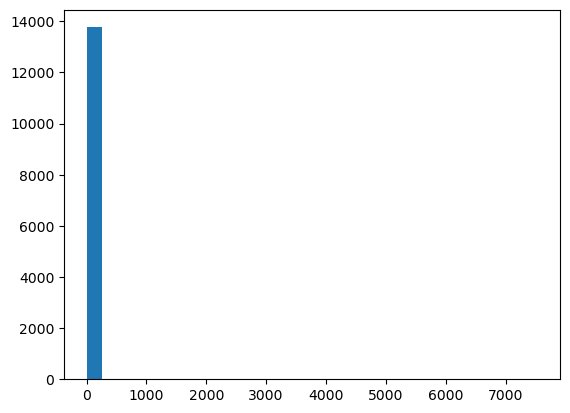

In [101]:
import matplotlib.pyplot as plt

plt.hist(sorted_wcounts.values(), bins=30)

(array([1.3767e+04, 1.9000e+01, 6.0000e+00, 3.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 2.52066667e+02, 5.03133333e+02, 7.54200000e+02,
        1.00526667e+03, 1.25633333e+03, 1.50740000e+03, 1.75846667e+03,
        2.00953333e+03, 2.26060000e+03, 2.51166667e+03, 2.76273333e+03,
        3.01380000e+03, 3.26486667e+03, 3.51593333e+03, 3.76700000e+03,
        4.01806667e+03, 4.26913333e+03, 4.52020000e+03, 4.77126667e+03,
        5.02233333e+03, 5.27340000e+03, 5.52446667e+03, 5.77553333e+03,
        6.02660000e+03, 6.27766667e+03, 6.52873333e+03, 6.77980000e+03,
        7.03086667e+03, 7.28193333e+03, 7.53300000e+03]),
 <BarContainer object of 30 

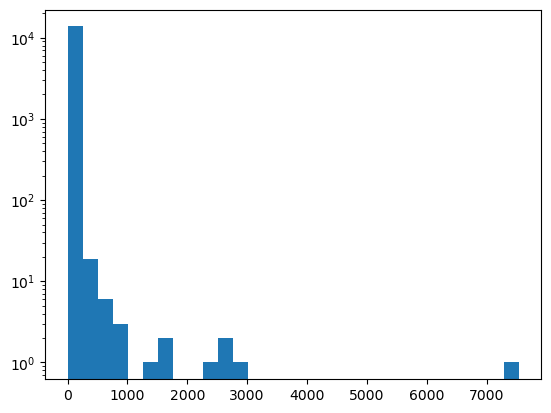

In [102]:
plt.hist(sorted_wcounts.values(), log=True, bins=30)

In [103]:
filtered_words = {k:v for k,v in sorted_wcounts.items() if v >= 10 and v < 50}
logger.info(list(filtered_words.keys()))
logger.info(f'length of selected words for manual check: {len(filtered_words.keys())}')

2024-03-02 09:42:50.370 | INFO     | __main__:<module>:2 - ['children', 'opened', 'perfect', 'established', 'river.', 'skate', 'flora', 'seating', 'nature', 'wetland', 'wall', 'years', 'continue', 'until', 'even', 'located', 'eastern', 'buildings', 'fountain', 'sit', 'family', 'black', 'shopping', 'known', 'wildlife', 'market', 'lookout', 'once', 'museum', 'head', "don't", 'cafe', 'run', 'nice', 'during', 'rock', 'facilities', 'gravel', 'check', 'such', 'plants', 'ducks', 'indigenous', 'national', 'court', 'tower', 'work', 'north', 'how', 'need', 'council', 'while', 'seat', 'bendigo', 'them', 'queen', 'post', 'access', 'come', 'train', 'gum', 'port', 'no', 'visit', 'front', 'wide', 'trees.', 'available', 'high', 'areas', 'species', 'top', 'bush', 'fire', 'section', 'interesting', 'wild', 'valley', 'murray', 'named', 'do', 'west', 'pool', 'sure', 'signs', 'day', 'past', 'always', 'fishing', 'swimming', 'outdoor', 'love', 'shops', 'both', 'bit', 'tennis', "there's", 'birdlife', 'boat', '

In [145]:
filtered_place_names = ['newport', 'Newport', 'collins', 'Collins', 'mildura', 'Mildura', 'esplanade', 'Esplanade',
                        'kensington', 'Kensington', 'australia', 'Australia', 'williamstown', 'Williamstown',
                        'ringwood', 'Ringwood', 'ballarat', 'Ballarat', 'beechworth', 'Beechworth', 'batman', 'Batman',
                        'dandenong', 'Dandenong', 'federation', 'Federation', 'flinders', 'Flinders', 'werribee', 'Werribee',
                        'braybrook', 'Braybrook', 'reservoir', 'Reservoir', 'horsham', 'Horsham', 'mornington', 'Mornington',
                        'bendigo', 'Bendigo', 'cardwell', 'Cardwell', 'st. kilda', 'St. Kilda', 
                        'merri', 'Merri', 'kyneton', 'Kyneton', 'barwon', 'Barwon', 'victoria', 'Victoria', 
                        'darebin', 'Darebin', 'birrarung', 'Birrarung', 'echuca', 'Echuca',
                        'runnymede', 'Runnymede', 'weeroona', 'Weeroona', 'ivanhoe', 'Ivanhoe',
                        'strezlecki', 'Strezlecki', 'balyang', 'Balyang', 'treganowan', 'Treganowan',
                        'wimmera', 'Wimmera', 'altona', 'Altona', 'ferguson', 'Ferguson', 
                        'kathleen', 'Kathleen', 'michie', 'Michie', 'wilkinson', 'Wilkinson', 'recwest', 'Recwest',
                        'rosalind', 'Rosalind', 'narraccan', 'Narraccan', 'ryberg', 'Ryberg', 'iramoo', 'Iramoo', 'narracan', 'Narracan']

In [146]:
import re
from pattern.text.en import singularize

def replace_by_list(desc, names):
    for n in names:
        if n in desc:
            desc = desc.replace(n, '')
    return desc

def refined_description(row):
    desc = row['description']
    desc = replace_by_list(desc, lga_names)
    desc = replace_by_list(desc, lga_names_lower)
    desc = replace_by_list(desc, suburb_names)
    desc = replace_by_list(desc, filtered_place_names)
    desc = replace_by_list(desc, suburb_names_lower)
    desc = re.sub('[0-9]', '', desc)  # remove numbers
    return ' '.join([singularize(token) for token in desc.split()])

In [147]:
gdf['refined_description'] = gdf.apply(refined_description, axis=1)

In [148]:
gdf.head()

,poi_title,poi_summary,latitude,longitude,geometry,description,refined_description
0,Fairhaven Surf Life Saving Club,Fairhaven is a well known surf beach. The beac...,-38.468759,144.084459,POINT (144.08446 -38.46876),Fairhaven Surf Life Saving Club: Fairhaven is ...,Surf Life Saving Club: is a well known surf be...
1,Beach walk,"From Sprout Creek, Eastern View, Moggs Creek, ...",-38.468542,144.089693,POINT (144.08969 -38.46854),"Beach walk: From Sprout Creek, Eastern View, M...","Beach walk: From Sprout Creek, , , to the bott..."
2,Rock pools,See what sort of shells and stones you can col...,-38.468459,144.092420,POINT (144.09242 -38.46846),Rock pools: See what sort of shells and stones...,Rock pools: See what sort of shell and stone y...
3,Sand dunes,The beautiful rolling sand dunes shape the bea...,-38.468418,144.095318,POINT (144.09532 -38.46842),Sand dunes: The beautiful rolling sand dunes s...,Sand dunes: The beautiful rolling sand dune sh...
4,Painkalac Creek,The creek separates Aireys Inlet from Fairhave...,-38.468390,144.097312,POINT (144.09731 -38.46839),Painkalac Creek: The creek separates Aireys In...,Painkalac Creek: The creek sete from and form ...


In [200]:
refined_docs = list(gdf['refined_description'])

refind_model_path = 'outputs/model/refined_poi_descriptions'

if os.path.isfile(refind_model_path) and not overwrite:
    logger.info('loading refined model from outputs folder')
    refined_topic_model = BERTopic.load(refind_model_path)
    refined_topics = refined_topic_model.topics_
    refined_probs = refined_topic_model.probabilities_
    logger.info('The refined model from outputs folder is loaded')
else:
    logger.info('A refined model not found in the outputs folder')
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    refined_topic_model = BERTopic(umap_model=umap_model, ctfidf_model=ctfidf_model)
    refined_topics, refined_probs = refined_topic_model.fit_transform(refined_docs)
    refined_topic_model.save(refind_model_path, serialization='pickle')
    logger.info('saving refined model from outputs folder')

2024-03-02 11:39:01.798 | INFO     | __main__:<module>:7 - loading refined model from outputs folder
2024-03-02 11:39:03.462 | INFO     | __main__:<module>:11 - The refined model from outputs folder is loaded


In [201]:
refined_topic_info = refined_topic_model.get_topic_info()
refined_topic_info.to_csv('outputs/dataframes/refined-topic.csv')

In [202]:
experiment_name = 'refined-poi'

intertopic_distance_map_html_path = f'outputs/figure/intertopic-dmap-{experiment_name}.html'
intertopic_distance_map_image_path = f'outputs/figure/intertopic-dmap-{experiment_name}.png'

topic_hierarchy_html_path = f'outputs/figure/topic-hierarchy-{experiment_name}.html'
topic_hierarchy_image_path = f'outputs/figure/topic-hierarchy-{experiment_name}.png'

detailed_topic_hierarchy_html_path = f'outputs/figure/detailed-topic-hierarchy-{experiment_name}.html'
detailed_topic_hierarchy_image_path = f'outputs/figure/detailed-topic-hierarchy-{experiment_name}.png'

barchart_html_path = f'outputs/figure/barchart-{experiment_name}.html'
barchart_image_path = f'outputs/figure/barchart-{experiment_name}.png'

heatmap_html_path = f'outputs/figure/heatmap-{experiment_name}.html'
heatmap_image_path = f'outputs/figure/heatmap-{experiment_name}.png'

In [203]:
fig = refined_topic_model.visualize_topics()
if overwrite:
    fig.write_html(intertopic_distance_map_html_path)
    fig.write_image(intertopic_distance_map_image_path)
    logger.info('saving refined model results')

fig

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [204]:
fig = refined_topic_model.visualize_hierarchy()
if overwrite:
    logger.info('saving refined model results')
    fig.write_html(topic_hierarchy_html_path)
    fig.write_image(topic_hierarchy_image_path)

fig

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:353: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead



In [205]:
# what happen when merging topics as well
hierarchical_refined_topics = refined_topic_model.hierarchical_topics(refined_docs)
fig = refined_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_refined_topics)
if overwrite:
    logger.info('saving refined model results')
    fig.write_html(detailed_topic_hierarchy_html_path)
    fig.write_image(detailed_topic_hierarchy_image_path)

fig

  0%|          | 0/68 [00:00<?, ?it/s]

100%|██████████| 68/68 [00:00<00:00, 149.17it/s]
d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:353: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\io\_renderers.py:39

In [206]:
# topic outlier reduction - if necessary (todo)
refined_topics = refined_topic_model.reduce_outliers(refined_docs, refined_topics, strategy="c-tf-idf")

refined_topic_df = pd.DataFrame({'topic': refined_topics, 'document': refined_docs})

In [207]:
refined_topic_df.to_csv('outputs/dataframes/refined-topic-poi-description.csv')

In [208]:
n_unique_refiend_topics = len(set(refined_topics))
n_unique_refiend_topics

70

In [209]:

fig = refined_topic_model.visualize_barchart(top_n_topics=n_unique_refiend_topics)
if overwrite:
    logger.info('saving refined model results')
    fig.write_html(barchart_html_path)
    fig.write_image(barchart_image_path)

fig

In [210]:
refined_topic_df.reset_index(inplace=True)

refined_topic_df['is_found'] = refined_topic_df.apply(is_found, axis=1)
refined_topic_df['class'] = refined_topic_df.apply(which_class_type, axis=1)

refined_topic_agg_df = refined_topic_df.groupby(['topic']).agg({'is_found': ['sum', 'count']})

refined_topic_agg_df[('is_found', 'ratio')] = refined_topic_agg_df[('is_found', 'sum')] / refined_topic_agg_df[('is_found', 'count')]

refined_topic_agg_df.reset_index(inplace=True)

refined_topic_agg_df.sort_values(by=('is_found', 'ratio'), inplace=True)


In [231]:
not_founds = list(refined_topic_agg_df.head(20)['topic'])
for idx in not_founds:
    print(refined_topic_model.get_topic_info(idx)['Representation'].values[0])

['gym', 'equipment', 'exercise', 'outdoor', 'fitnes', 'consist', 'ups', 'gear', 'sport', 'crunch']
['fishing', 'trout', 'fish', 'try', 'kingfisher', 'cano', 'anglers', 'teach', 'azure', 'catching']
['fungi', 'mushroom', 'appearance', 'mushrooms', 'daffodil', 'spider', 'did', 'descend', 'feet', 'invited']
['wild', 'notforprofit', 'engagement', 'website', 'connecting', 'specialising', 'nature', 'dcated', 'completed', 'please']
['bird', 'duck', 'birdlife', 'hide', 'nesting', 'pelicans', 'ducks', 'feng', 'birds', 'pelican']
['skink', 'tall', 'covering', 'dawson', 'detection', 'enhancement', 'schlerophyll', 'frogmouths', 'thickening', 'tawny']
['gum', 'gums', 'red', 'gumtree', 'felled', 'fernery', 'twisting', 'carving', 'stabilising', 'flowering']
['boardwalk', 'boardwalks', 'allows', 'wet', 'ish', 'foot', 'relatively', 'schnapper', 'jawbone', 'raised']
['echidna', 'animal', 'koala', 'kookaburra', 'rustle', 'safarus', 'magistrates', 'wildlife', 'zoo', 'creature']
['creek', 'leary', 'roderic

In [212]:
founds = list(refined_topic_agg_df.tail(20)['topic'])
for idx in founds:
    print(refined_topic_model.get_topic_info(idx)['Representation'].values[0])

['aboriginal', 'gertrude', 'koorus', 'established', 'health', 'political', 'service', 'homeles', 'kollij', 'combat']
['golden', 'dragon', 'zombie', 'wider', 'helen', 'mingling', 'shuffling', 'villagebet', 'yoga', 'disgusting']
['cottage', 'building', 'chartered', 'dlly', 'lon', 'operate', 'wares', 'nswwestpac', 'yr', 'proudfoot']
['brook', 'hub', 'community', 'library', 'neighbourhood', 'information', 'classes', 'albanian', 'program', 'centre']
['pools', 'rock', 'luna', 'rockpool', 'bristle', 'fascinated', 'gales', 'hopping', 'brittle', 'gull']
['court', 'polouse', 'county', 'law', 'supreme', 'accountant', 'solicitor', 'carlton', 'privately', 'judge']
['bakery', 'coffee', 'shop', 'restaurant', 'cafe', 'market', 'store', 'shopping', 'meat', 'caf']
['free', 'ages', 'playground', 'table', 'barbeque', 'overnight', 'nicely', 'bellin', 'charge', 'rumbling']
['church', 'uniting', 'cathedral', 'methodist', 'anglican', 'presbyterian', 'sacred', 'cic', 'heart', 'christ']
['garden', 'gardens', 'b

In [213]:
refined_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_refined_topics)

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\figure_factory\_dendrogram.py:353: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

d:\Programming\leisure-walking-analysis\.conda\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes

In [214]:
# 45? 55? 66?
labelled_topics = {'0_nature_flora and funa': [57,58,14,1,11,9,21,48,65,40,43,56],
                   '0_nature_natural landmarks': [25,4,10],

                   '1_activities_fishing to surfing': [59,27,29,22,68,28],
                   '1_activties_picnic area': [13,31,16,61,42,5,7],
                   '1_activities_food and beverage': [3],
                   '1_activities_sport complexes': [23,44,53,49,36,62],

                   '2_society_human made landmarks': [34,54,30,37,50,12],
                   '2_society_art, history and culture': [51,6,8,15,60,63,33,38,17,64,24,52,32,39,18,41],

                   '3_transport_trail-path-and-canal': [20,2,0,19,26,67],  # trails, signs and rules
                   '3_transport_lines and stations': [47,27,46,53],
                   
                   '4_unknown_unknown': [-1,66,55,45]
                  }

# move from nature without people (flora and funa) -- > to only people --> to transport and signs


In [215]:
sum([len(labelled_topics[key]) for key in labelled_topics.keys()])

70

In [216]:
def labelled_stats(topic_ids, labelled_topics = labelled_topics):
    stat_topics = {}
    for idx in topic_ids:
        for key, values in labelled_topics.items():
            if idx in values:
                if key not in stat_topics.keys():
                    stat_topics[key] = 1
                else:
                    stat_topics[key] += 1
    return stat_topics

In [217]:
not_found_topics = labelled_stats(not_founds)
not_found_topics

{'1_activities_fishing to surfing': 2,
 '0_nature_flora and funa': 10,
 '4_unknown_unknown': 1,
 '3_transport_trail-path-and-canal': 1,
 '0_nature_natural landmarks': 1,
 '1_activties_picnic area': 2,
 '2_society_art, history and culture': 1,
 '3_transport_lines and stations': 2}

In [218]:
found_topics = labelled_stats(founds)
found_topics

{'2_society_art, history and culture': 8,
 '4_unknown_unknown': 3,
 '2_society_human made landmarks': 4,
 '1_activities_food and beverage': 1,
 '1_activties_picnic area': 1,
 '1_activities_fishing to surfing': 1,
 '1_activities_sport complexes': 1,
 '3_transport_lines and stations': 1}

In [219]:
refined_topic_agg_df

topic is_found                
              sum count     ratio
36    35        0    32  0.000000
30    29        0    44  0.000000
57    56        0    21  0.000000
56    55        0    21  0.000000
2      1        3   188  0.015957
..   ...      ...   ...       ...
42    41       13    36  0.361111
47    46       19    49  0.387755
46    45       21    45  0.466667
0     -1        9    17  0.529412
35    34       17    31  0.548387

[70 rows x 4 columns]

In [220]:
def label_topic_func(row):
    topic_id = int(row['Topic'])
    for key, ids in labelled_topics.items():
        if topic_id in ids:
            key_split = key.split('_')
            row['Class ID'] = int(key_split[0])
            row['Class'] = key_split[1]
            row['Subclass'] = key_split[2]
    return row

In [224]:
refined_topic_info = refined_topic_info.apply(label_topic_func, axis=1)
refined_topic_info.to_csv('outputs/dataframes/refined-topics-classified.csv')

In [227]:
refined_topic_info

,Class,Class ID,Count,Name,Representation,Representative_Docs,Subclass,Topic
0,unknown,4.0,1347,-1_reserve_weir_site_been,"[reserve, weir, site, been, avenue, street, ha...",[The creek: There are several great view of th...,unknown,-1
1,transport,3.0,565,0_track_gravel_river_path,"[track, gravel, river, path, steep, walking, l...",[While the car slog away above it peaceful dow...,trail-path-and-canal,0
2,nature,0.0,150,1_bird_duck_birdlife_hide,"[bird, duck, birdlife, hide, nesting, pelicans...",[Bird hide and bng: Thi bird hide is the perfe...,flora and funa,1
3,transport,3.0,139,2_bridge_footbridge_pedestrian_cros,"[bridge, footbridge, pedestrian, cros, heavenl...",[Pedestrian bridge under Broadmedow Road: A gr...,trail-path-and-canal,2
4,activities,1.0,137,3_bakery_coffee_shop_restaurant,"[bakery, coffee, shop, restaurant, cafe, marke...",[Cake shop: Thi shop ha a fine display in the ...,food and beverage,3
...,...,...,...,...,...,...,...,...
65,society,2.0,11,64_golden_dragon_zombie_wider,"[golden, dragon, zombie, wider, helen, minglin...",[Zombie mingling point: zombies have an hmy be...,"art, history and culture",64
66,nature,0.0,11,65_orchid_orchids_waxlip_greenhood,"[orchid, orchids, waxlip, greenhood, sp, noddi...",[Nodding Greenhood Orchid: These beautiful orc...,flora and funa,65
67,unknown,4.0,11,66_pools_rock_luna_rockpool,"[pools, rock, luna, rockpool, bristle, fascina...",[Expansive view and little rock pools.: The oc...,unknown,66
68,transport,3.0,11,67_oscar_underpas_trail_blind,"[oscar, underpas, trail, blind, shared, creek,...",[Oscar Walk: Oscar Walk beside the Bank start ...,trail-path-and-canal,67


In [226]:
refined_topic_df

,index,topic,document,is_found,class
0,0,4,Surf Life Saving Club: is a well known surf be...,False,None
1,1,4,"Beach walk: From Sprout Creek, , , to the bott...",False,None
2,2,66,Rock pools: See what sort of shell and stone y...,False,None
3,3,4,Sand dunes: The beautiful rolling sand dune sh...,False,None
4,4,25,Painkalac Creek: The creek sete from and form ...,False,None
...,...,...,...,...,...
4387,4387,9,Lot of native flora: There are many native tre...,False,None
4388,4388,0,Continue the loop or go elsewhere: There are p...,False,None
4389,4389,0,Residential Street: Thi section of the walk ta...,False,None
4390,4390,7,The Stable Playground: Thi playground is huge ...,False,None


In [229]:
refined_topic_poi_description = pd.merge(refined_topic_df, refined_topic_info, left_on='topic', right_on='Topic', how='inner').drop('Topic', axis=1)
refined_topic_poi_description.to_csv('outputs/dataframes/refined-topic-poi-description-classified.csv')

#### NOTE:

To what level the hierarchical clustering matches the manual classification? 

A tree based edit distance could be a quant to answer this question: check: https://github.com/timtadh/zhang-shasha

## Labelling Process:

- label if the geocoding was correct - if geocoding was successful
- find 10 most likely using textual and spatial criteria and record the element as a match

In [233]:
classes_found = list(refined_topic_df['class'].unique())
sup_classes = set([c.split(' ')[0] for c in classes_found if c is not None])
logger.info(f'OSM keys of nominatim results: {sup_classes}')
logger.debug(f'all key values of extracted OSM matches: {classes_found}')

2024-03-02 16:14:48.534 | INFO     | __main__:<module>:3 - OSM keys of nominatim results: {'building', 'railway', 'shop', 'leisure', 'historic', 'highway', 'boundary', 'tourism', 'place', 'man_made', 'waterway', 'landuse', 'amenity', 'club', 'natural', 'office', 'bridge'}


In [234]:
logger.info('creating a comprehensive list of tags for searching POIs in OSM')
tags = dict([(k, True) for k in sup_classes])
tags['animal'] = True
logger.info(tags)

2024-03-02 16:15:33.071 | INFO     | __main__:<module>:1 - creating a comprehensive list of tags for searching POIs in OSM
2024-03-02 16:15:33.073 | INFO     | __main__:<module>:4 - {'building': True, 'railway': True, 'shop': True, 'leisure': True, 'historic': True, 'highway': True, 'boundary': True, 'tourism': True, 'place': True, 'man_made': True, 'waterway': True, 'landuse': True, 'amenity': True, 'club': True, 'natural': True, 'office': True, 'bridge': True, 'animal': True}


In [235]:
def get_feature_from_osm(lat, lng, dist=200, tags=tags):
    return ox.features_from_point((lat, lng), tags, dist)

In [236]:
case_id = 23
test_case = nominatim_output[str(case_id)]

In [237]:
test_case

{'walk_id': 2,
 'title': '13. Royal Exhibition Building',
 'summary': 'The Royal Exhibition Building is the only surviving Great Hall that once housed a 19th-century international exhibition and is still used for exhibitions. ',
 'lat': -37.80513488,
 'lng': 144.97123539,
 'osm': {'place_id': 17546919,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': 4817059,
  'lat': '-37.804666850000004',
  'lon': '144.9714669305319',
  'class': 'historic',
  'type': 'building',
  'place_rank': 30,
  'importance': 0.39044459367468287,
  'addresstype': 'historic',
  'name': 'Royal Exhibition Building',
  'display_name': 'Royal Exhibition Building, 9, Nicholson Street, Carlton, Melbourne, City of Melbourne, Victoria, 3053, Australia',
  'boundingbox': ['-37.8051500', '-37.8041865', '144.9705305', '144.9724671']}}

In [238]:
dist_threshold = 200
features = get_feature_from_osm(test_case['lat'], test_case['lng'], dist=dist_threshold)
features

highway traffic_signals:direction  \
element_type osmid                                             
node         319157917         NaN                       NaN   
             368393200         NaN                       NaN   
             371974432         NaN                       NaN   
             493873180    crossing                       NaN   
             501027469    crossing                       NaN   
...                            ...                       ...   
relation     13238592   pedestrian                       NaN   
             16464561          NaN                       NaN   
             16505481   pedestrian                       NaN   
             17205856          NaN                       NaN   
             17205857          NaN                       NaN   

                                                                 geometry  \
element_type osmid                                                          
node         319157917                        POINT (144.96920 -37.80626)   
             368393200                        POINT (144.97064 -37.80351)   
             371974432                        POINT (144.97138 -37.80545)   
             493873180                        POINT (144.96961 -37.80495)   
             501027469                        POINT (144.97350 -37.80553)   
...                                                                   ...   
relation     13238592   POLYGON ((144.97319 -37.80469, 144.97316 -37.8...   
             16464561   POLYGON ((144.96877 -37.80399, 144.96879 -37.8...   
             16505481   POLYGON ((144.97232 -37.80461, 144.97205 -37.8...   
             17205856   POLYGON ((144.97222 -37.80608, 144.97215 -37.8...   
             17205857   POLYGON ((144.97004 -37.80614, 144.97007 -37.8...   

                       access   amenity  fee                operator  \
element_type osmid                                                     
node         319157917    yes   toilets   no  Melbourne City Council   
             368393200    NaN    cinema  NaN        Melbourne museum   
             371974432    NaN  fountain  NaN                     NaN   
             493873180    NaN       NaN  NaN                     NaN   
             501027469    NaN       NaN  NaN                     NaN   
...                       ...       ...  ...                     ...   
relation     13238592     NaN       NaN  NaN                     NaN   
             16464561     NaN       NaN  NaN                     NaN   
             16505481     NaN       NaN  NaN                     NaN   
             17205856     NaN       NaN  NaN                     NaN   
             17205857     NaN       NaN  NaN                     NaN   

                       toilets:disposal unisex wheelchair  ... name:mk  \
element_type osmid                                         ...           
node         319157917            flush    yes        yes  ...     NaN   
             368393200              NaN    NaN        NaN  ...     NaN   
             371974432              NaN    NaN        NaN  ...     NaN   
             493873180              NaN    NaN        NaN  ...     NaN   
             501027469              NaN    NaN        NaN  ...     NaN   
...                                 ...    ...        ...  ...     ...   
relation     13238592               NaN    NaN        NaN  ...     NaN   
             16464561               NaN    NaN        NaN  ...     NaN   
             16505481               NaN    NaN        NaN  ...     NaN   
             17205856               NaN    NaN        NaN  ...     NaN   
             17205857               NaN    NaN        NaN  ...     NaN   

                       short_name political_division heritage  \
element_type osmid                                              
node         319157917        NaN                NaN      NaN   
             368393200        NaN                NaN      NaN   
             371974432        Na

In [240]:
logger.info(f'list of features from OSM results: {list(features.columns)}')

2024-03-02 16:17:10.873 | INFO     | __main__:<module>:1 - list of features from OSM results: ['highway', 'traffic_signals:direction', 'geometry', 'access', 'amenity', 'fee', 'operator', 'toilets:disposal', 'unisex', 'wheelchair', 'crossing', 'check_date', 'name', 'payment:mastercard', 'payment:visa', 'phone', 'screen', 'website', 'wikidata', 'bicycle', 'artist', 'covered', 'drinking_water', 'indoor', 'tactile_paving', 'button_operated', 'crossing:markings', 'foot', 'traffic_signals:sound', 'traffic_signals:vibration', 'backrest', 'source', 'railway', 'parking', 'crossing:island', 'kerb', 'bicycle_parking', 'fountain', 'leisure', 'brand', 'brand:wikidata', 'brand:wikipedia', 'operator:wikidata', 'operator:wikipedia', 'payment:cash', 'payment:credit_cards', 'toilets:wheelchair', 'place', 'network', 'public_transport', 'ref', 'tram', 'natural', 'bench', 'bin', 'bus', 'lit', 'network:wikidata', 'network:wikipedia', 'ref:ptv_website', 'route_ref', 'shelter', 'capacity', 'location', 'histor

In [244]:
for key, value in nominatim_output.items():
    logger.debug('key: {}'.format(key))
    if os.path.isfile('dataset/osm-poi-{0}-dist-{1}-features.geojson'.format(key, dist_threshold)):
        logger.debug('already investigated...')
        continue;
    try:
        # only set for next round - first run dist=200 to collect initial results and the empty frames are completed by considering 1000 meters thresholds.
        features = get_feature_from_osm(value['lat'], value['lng'], dist=1000)
        cols = list(features.columns)
        cols.remove('geometry')
        features[cols] = features[cols].astype(str)
        features.to_file('dataset/osm-poi-{0}-dist-{1}-features.geojson'.format(key, dist_threshold), driver="GeoJSON") 
        logger.info('done')
    except Exception as e:
        logger.warning(e)

In [245]:
import pyproj
from shapely.geometry import Point
from shapely.ops import transform

wgs84_pt = Point(test_case['lng'], test_case['lat'])
wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:32755')

project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

utm_point = transform(project, wgs84_pt)

features = gpd.read_file('dataset/osm-poi-{0}-dist-{1}-features.geojson'.format(case_id, dist_threshold))
features = features.to_crs('EPSG:32755')

features['distance'] = [utm_point.distance(geom) for geom in features.geometry]

In [246]:
features

,element_type,osmid,highway,traffic_signals:direction,access,amenity,fee,operator,toilets:disposal,unisex,...,source:population,name:mk,short_name,political_division,heritage,heritage:operator,heritage:website,area,geometry,distance
0,node,319157917,nan,nan,yes,toilets,no,Melbourne City Council,flush,yes,...,nan,nan,nan,nan,nan,nan,nan,nan,POINT (321223.384 5813738.129),218.599034
1,node,368393200,nan,nan,nan,cinema,nan,Melbourne museum,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,POINT (321343.567 5814046.274),188.373535
2,node,371974432,nan,nan,nan,fountain,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,POINT (321413.415 5813831.827),37.211904
3,node,493873180,crossing,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,POINT (321256.686 5813883.765),144.563983
4,node,501027469,crossing,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,POINT (321600.961 5813827.093),204.586235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,relation,6614802,nan,nan,nan,nan,nan,Melbourne City Council,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,"MULTIPOLYGON (((321219.805 5813634.926, 321210...",3.048837
436,relation,6623509,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,1,whc,http://whc.unesco.org/en/list/1131,nan,"MULTIPOLYGON (((321415.382 5813963.959, 321416...",3.048837
437,relation,13238592,pedestrian,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,yes,"POLYGON ((321571.451 5813919.342, 321569.416 5...",96.331620
438,relation,16464561,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,"POLYGON ((321163.337 5813990.989, 321180.796 5...",209.794588


In [247]:
# filter geometry, distance
# filter nan, no values
# filter values for yes
# involve name, short_name if not nan first
# location inside if exists!
not_consider = ['geometry', 'distance', 'element_type', 'osmid']
consider_first = ['name', 'short_name']
cols = list(features.columns)

In [248]:
def generate_textual_descriptions(row, cols=cols):
    full_name = ''
    for c in consider_first:
        if c in cols and row[c] != 'nan':
            full_name += ' ' + row[c]
    for c in cols:
        if c not in consider_first and c not in not_consider and ':' not in c and row[c] != 'nan' and row[c] != 'no' and 'http' not in row[c] and '[' not in row[c] and 'wiki' not in c:
            if row[c] == 'yes':
                full_name += ' ' + c
            else:
                full_name += ' {0} {1}'.format(c, row[c])
    return full_name.strip()

In [249]:
features['full_name'] = features.apply(generate_textual_descriptions, axis=1)
features

,element_type,osmid,highway,traffic_signals:direction,access,amenity,fee,operator,toilets:disposal,unisex,...,name:mk,short_name,political_division,heritage,heritage:operator,heritage:website,area,geometry,distance,full_name
0,node,319157917,nan,nan,yes,toilets,no,Melbourne City Council,flush,yes,...,nan,nan,nan,nan,nan,nan,nan,POINT (321223.384 5813738.129),218.599034,access amenity toilets operator Melbourne City...
1,node,368393200,nan,nan,nan,cinema,nan,Melbourne museum,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,POINT (321343.567 5814046.274),188.373535,IMAX Melbourne amenity cinema operator Melbour...
2,node,371974432,nan,nan,nan,fountain,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,POINT (321413.415 5813831.827),37.211904,amenity fountain
3,node,493873180,crossing,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,POINT (321256.686 5813883.765),144.563983,highway crossing crossing zebra
4,node,501027469,crossing,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,POINT (321600.961 5813827.093),204.586235,highway crossing crossing traffic_signals tact...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,relation,6614802,nan,nan,nan,nan,nan,Melbourne City Council,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,"MULTIPOLYGON (((321219.805 5813634.926, 321210...",3.048837,Carlton Gardens operator Melbourne City Counci...
436,relation,6623509,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,1,whc,http://whc.unesco.org/en/list/1131,nan,"MULTIPOLYGON (((321415.382 5813963.959, 321416...",3.048837,Royal Exhibition Building and Carlton Gardens ...
437,relation,13238592,pedestrian,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,yes,"POLYGON ((321571.451 5813919.342, 321569.416 5...",96.331620,highway pedestrian type multipolygon area
438,relation,16464561,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,"POLYGON ((321163.337 5813990.989, 321180.796 5...",209.794588,building type multipolygon


In [256]:
def compute_similarities_topk(query, sentences, sentence_embeddings, model=sbert_model, k=10, verbose=False):
    query_vec = embed_texts(query)
    scores = util.dot_score(query_vec, sentence_embeddings)[0].cpu().tolist()
    doc_score_pairs = list(zip(sentences, scores))
    doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)
    if verbose:
        logger.info(f"Query: {query}")
        for doc, score in doc_score_pairs:
            logger.info(f'\t{score}\t{doc}')
    return np.argsort(scores)[-k:]

In [257]:
# example_sentence_embeddings = embed_texts(example_sentences, model=msmarco_model)
# compute_similarities(example_poi_osm, example_sentences, example_sentence_embeddings, model=msmarco_model)
feature_descriptions = list(features['full_name'])
feature_embeddings = embed_texts(feature_descriptions, model=msmarco_model)
case_description = nominatim_output[str(case_id)]['title'] + ' ' + nominatim_output[str(case_id)]['summary']
k_similar = compute_similarities_topk(case_description, feature_descriptions, feature_embeddings, model=msmarco_model, verbose=True)
k_similar

2024-03-02 16:23:03.594 | INFO     | __main__:compute_similarities_topk:7 - Query: 13. Royal Exhibition Building The Royal Exhibition Building is the only surviving Great Hall that once housed a 19th-century international exhibition and is still used for exhibitions. 
2024-03-02 16:23:03.596 | INFO     | __main__:compute_similarities_topk:9 - 	44.04184341430664	Royal Exhibition Building and Carlton Gardens tourism attraction type multipolygon heritage 1
2024-03-02 16:23:03.596 | INFO     | __main__:compute_similarities_topk:9 - 	40.16721725463867	Royal Exhibition Building source Vicmap Address historic building tourism attraction building height 20 layer 1
2024-03-02 16:23:03.598 | INFO     | __main__:compute_similarities_topk:9 - 	39.15629196166992	Royal Exhibition Building Opening historic memorial memorial plaque
2024-03-02 16:23:03.599 | INFO     | __main__:compute_similarities_topk:9 - 	36.941375732421875	Melbourne Museum fee operator Museum Victoria wheelchair phone +61 3 8341 77

array([ 46,   1,  26,  27,  44,  49, 298,  43, 297, 436], dtype=int64)

In [258]:
features.iloc[k_similar]

,element_type,osmid,highway,traffic_signals:direction,access,amenity,fee,operator,toilets:disposal,unisex,...,name:mk,short_name,political_division,heritage,heritage:operator,heritage:website,area,geometry,distance,full_name
46,node,9106562132,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,POINT (321559.646 5813927.545),170.659614,artwork_type sculpture tourism artwork
1,node,368393200,nan,nan,nan,cinema,nan,Melbourne museum,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,POINT (321343.567 5814046.274),188.373535,IMAX Melbourne amenity cinema operator Melbour...
26,node,4061250667,bus_stop,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,POINT (321243.477 5813954.530),179.719018,Exhibition Building/Rathdowne Street highway b...
27,node,4332324003,nan,nan,nan,charging_station,nan,Museums Victoria,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,POINT (321463.713 5813962.011),114.580080,amenity charging_station operator Museums Vict...
44,node,7248901076,bus_stop,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,POINT (321211.629 5813902.092),191.907516,Exhibition Building/Rathdowne Street highway b...
49,node,9307551791,nan,nan,yes,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,POINT (321592.650 5813874.406),192.577146,access historic monument inscription To Victor...
298,way,4817074,nan,nan,nan,nan,yes,Museum Victoria,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,"POLYGON ((321505.691 5814023.082, 321459.066 5...",159.043248,Melbourne Museum fee operator Museum Victoria ...
43,node,6810298878,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,POINT (321503.096 5813888.150),105.093724,Royal Exhibition Building Opening historic mem...
297,way,4817059,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,"POLYGON ((321415.382 5813963.959, 321416.338 5...",11.700249,Royal Exhibition Building source Vicmap Addres...
436,relation,6623509,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,1,whc,http://whc.unesco.org/en/list/1131,nan,"MULTIPOLYGON (((321415.382 5813963.959, 321416...",3.048837,Royal Exhibition Building and Carlton Gardens ...


In [259]:
def get_top_k(case_id, k=10, model = msmarco_model, verbose=False):
    test_case = nominatim_output[str(case_id)]
    
    features = gpd.read_file('dataset/osm-poi-{0}-dist-{1}-features.geojson'.format(case_id, dist_threshold))
    cols = list(features.columns)
    if verbose:
        print(features.head())
        logger.info(cols)
    features['full_name'] = features.apply(lambda row: generate_textual_descriptions(row, cols), axis=1)
    
    feature_descriptions = list(features['full_name'])
    feature_embeddings = embed_texts(feature_descriptions, model=model)
    
    case_description = test_case['title'] + ' ' + test_case['summary']
    k_similar = compute_similarities_topk(case_description, feature_descriptions, feature_embeddings, model=model, verbose=verbose)
    return features.iloc[np.flip(k_similar)]

## Annotation Experiment

In [260]:
if os.path.isfile('dataset/annotated-osm-entities.json'):
    with open('dataset/annotated-osm-entities.json', 'r') as fp:
        annotations = json.load(fp)
else:
    annotations = {}
annotations

{'0': [['way', 1089591567]],
 '1': [['way', 1007494584]],
 '2': [],
 '3': [],
 '4': [['way', 30501938]],
 '5': [],
 '6': [['way', 69366108], ['node', 5315720235]],
 '7': [['node', 11158854687],
  ['node', 4583492091],
  ['node', 831201411],
  ['node', 11158854665],
  ['node', 11158854688]],
 '8': [['node', 3621405496]],
 '9': [],
 '10': [['node', 831201041]],
 '11': [['node', 3933086392]],
 '12': [['way', 26564416]],
 '13': [['way', 49961266]],
 '14': [['way', 26564392]],
 '15': [['node', 5371634608]],
 '16': [['node', 7228362154], ['way', 32710391]],
 '17': [['way', 435967756]],
 '18': [],
 '19': [],
 '20': [['way', 1016758027]],
 '21': [['node', 368393200]],
 '22': [['way', 4817074]],
 '23': [['way', 4817059]],
 '24': [['relation', 6614802]],
 '25': [['way', 29369985]],
 '26': [['way', 30066634]],
 '27': [['way', 830995835], ['way', 830995836], ['way', 830995837]],
 '28': [['node', 6515021014]],
 '29': [['node', 331165028]],
 '30': [['node', 243419251]],
 '31': [['node', 649798969]],

### Iterate from here!

In [298]:
already_investigated = [int(key) for key in annotations.keys()]
case_id = max(already_investigated) + 1
logger.info(case_id)
print(nominatim_output[str(case_id)])
top_k_df = get_top_k(case_id)
top_k_df[['element_type','osmid', 'name', 'full_name']]

2024-03-02 16:36:28.920 | INFO     | __main__:<module>:3 - 351


{'walk_id': 23, 'title': 'Zoo entrance', 'summary': 'Fancy a tour of the zoo? Buy your tickets here. ', 'lat': -37.78141777, 'lng': 144.95126002, 'osm': None}


,element_type,osmid,name,full_name
49,way,4749328,Melbourne Zoological Gardens,Melbourne Zoological Gardens Melbourne Zoo ope...
115,way,319803002,nan,building attraction animal zoo enclosure
54,way,25643763,nan,building attraction animal zoo enclosure
55,way,25643765,nan,building attraction animal zoo enclosure
37,node,4889720411,Wild Dogs Cafe,Wild Dogs Cafe amenity cafe
27,node,4520380565,Stop 26: Melbourne Zoo,Stop 26: Melbourne Zoo railway tram_stop opera...
28,node,4520380566,Stop 26: Melbourne Zoo,Stop 26: Melbourne Zoo railway tram_stop opera...
90,way,112648025,Stop 25: Melbourne Zoo,Stop 25: Melbourne Zoo railway platform operat...
86,way,112648019,Stop 25: Melbourne Zoo,Stop 25: Melbourne Zoo railway platform operat...
98,way,112648036,nan,amenity parking fee parking surface


In [299]:
gdf.iloc[case_id:case_id+1].explore(marker_type='marker')

In [300]:
print('https://www.openstreetmap.org/#map=18/{0}/{1}'.format(nominatim_output[str(case_id)]['lat'], nominatim_output[str(case_id)]['lng']))

https://www.openstreetmap.org/#map=18/-37.78141777/144.95126002


In [301]:
annotations[case_id] = [('way', 4749328)]
if len(annotations.keys()) % 10 == 0:
    with open('dataset/annotated-osm-entities.json', 'w', encoding='utf-8') as fp:
        json.dump(annotations, fp)
    logger.info('annotation file saved')
logger.info(f'captured {case_id}: {annotations[case_id]}')

2024-03-02 16:38:09.684 | INFO     | __main__:<module>:5 - annotation file saved
2024-03-02 16:38:09.685 | INFO     | __main__:<module>:6 - captured 351: [('way', 4749328)]


#### NOTES
How to create a easy tools for the annotations
    - getting and computing all computation for all records
    - create a simple tool for annotation - refer to Martin's suggestion to create widgets